In [27]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
import astropy.units as u
from astropy.wcs import wcs
from astropy.io import fits
from scipy import ndimage
from matplotlib.gridspec import GridSpec
from tempfile import TemporaryFile

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from importlib import reload

import os
os.chdir('/Users/felixmartinez/Research/scripts/')
import functions as func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of functions failed: Traceback (most recent call last):
  File "/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen 

### Importing important Data:

In [2]:
img_N = fits.open('/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst_v4.0_f160w/goodsn_3dhst.v4.0.F160W_orig_sci.fits')[0].data
seg_N = fits.open('/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst.v4.0.F160W_seg.fits')[0].data
segN_fits = '/Users/felixmartinez/Research/CANDLES/goods_data/goodsn_3dhst.v4.0.F160W_seg.fits'
w = wcs.WCS(segN_fits)

corrected_x = np.load('/Users/felixmartinez/Research/merger_detection/Rand_Ha/corrected_x_median.npy')
corrected_y = np.load('/Users/felixmartinez/Research/merger_detection/Rand_Ha/corrected_y_median.npy')
xrange = np.linspace(-30,30, 1000)
yrange = np.linspace(-30,30, 1000)

In [10]:
#Merger Candidates

#The failed arrays do not have Ha in their fitz files
#The Bad arrays have issues with subtraction/noise that may throw the data off

GN1 = [36808,37615,37810,36514,36928,37636,37821,37006,37363,37738,37836,36651,37807,38041,
       37067,37395,37750,36717,37074,37786,37996,36736,37102,37424,37787,38027,36795,37193]
GN1_bad = [36420,37343,37957,37406]
GN1_failed = [36577]

GN2 = [10101,11429,15544,18197,20948,10336,11526,15861,21720,10512,11941,15867,18642,21854,10528,
       12479,16033,18817,21918,10619,16083,18869,22265,10639,13037,18988,14621,20298,26882,11339,
       23667,10723,16753,19592,25616,11152,14780,17139,19860,25671,11228,15050,17626,15477,17635]
GN2_bad = [18315,16173,22417,10653,14713,20701]
GN2_failed = [12499,16375,19316]

GN3 = [26922,33422,34527,36054,27018,31179,33571,36406,27101,31788,33673,36433,27422,33135,34407,
       31957,33707,36720,27472,33732,35039,28593,32329,33764,35045,37171,28596,32905,34403,35264,35617]
GN3_bad = [29641,34562,34739,34747,32066,29325]
GN3_failed = [37053,37188]

GN4 = [15999,20073,22265,25734,28596,18400,20305,23381,26696,20319,23608,27018,29641,18763,
       20481,23889,27101,32229,19437,20635,27472,19485,21564,25393,27930,19493,25687,28593]
GN4_bad = [29325,18574,23936]
GN4_failed = [21814]

GN5 = [33764]
GN5_bad = [32562]
GN5_failed = [33571]

GN7 = [10964,13777,15300,19017,19875,11683,13821,15477,21152,13909,15544,19149,12713,14178,
       15761,19235,13466,14281,17927,19270,13750,19659]
GN7_bad = [11750,14597]
GN7_failed = [19088,18642]

#All of the failed arrays have no Ha in the fits files, It also has no Ha in CLEAR so that is ok

# Removing Noise
Due to the roughly general offset of minus 1 in the y direction, we believe there may be an issue in the median filter we are using. To ensure this is not the case, we must run a loop where we simulate a perfectly uniform galaxy about 1,000 times and find if the median filter is adding an offset in the y direction.

Perfect Galaxy Brightest location: (20,18)
Noise Galaxy Brightest location: (20,18)
Median Galaxy Brightest location: (20,19)
Gaussian Galaxy Brightest location: (20,20)


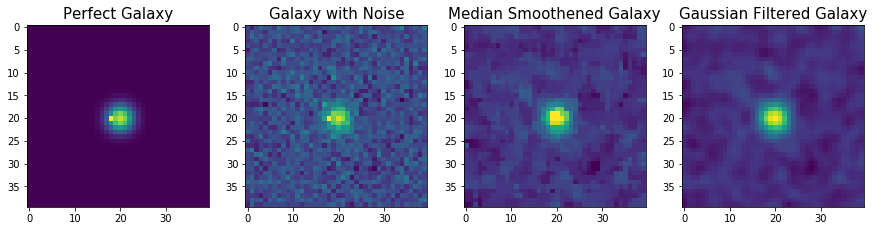

In [3]:
#First we must create a gaucian circle
RANGE = np.arange(0,40)
dist = func.gauss_dist(RANGE, 20,2)

IMG = np.zeros([len(RANGE), len(RANGE)])

for i in range(len(RANGE)):
    for ii in range(len(RANGE)):
        IMG[i][ii] = dist[i]*dist[ii]

#This is the Perfect circular galaxy
IMG /= np.max(IMG)                   

#Adding a random Bright Pixel within the galaxy
max_index = np.random.choice([18,19,20,21,22], 2)  #seclecting the location
max_val = 1.1 * np.max(IMG)                        #setting the bright pxl to be 1.1 X our previous bright pxl
IMG[max_index[0], max_index[1]]=max_val

#Adding noise:
NOISE = np.random.normal(0,0.1,size = IMG.shape)
NIMG = IMG + NOISE

#Adding a Median filter to the Noise:
MEDIMG = ndimage.median_filter(NIMG, size = (3,3))

#Trying a Gaussian filter
GAUSSIMG = ndimage.gaussian_filter(NIMG,1)

#Finding the Max Values of each Galaxy (They will be stored as [x,y])
IMG_max = np.where(IMG == np.max(IMG))
NIMG_max = np.where(NIMG == np.max(NIMG))
MEDIMG_max = np.where(MEDIMG == np.max(MEDIMG))    
GAUSS_max = np.where(GAUSSIMG == np.max(GAUSSIMG))

print("Perfect Galaxy Brightest location: ("+ str(IMG_max[0][0]) +","+ str(IMG_max[1][0])+")")
print("Noise Galaxy Brightest location: ("+ str(NIMG_max[0][0]) +","+ str(NIMG_max[1][0])+")")
print("Median Galaxy Brightest location: ("+ str(MEDIMG_max[0][0]) +","+ str(MEDIMG_max[1][0])+")")
print("Gaussian Galaxy Brightest location: ("+ str(GAUSS_max[0][0]) +","+ str(GAUSS_max[1][0])+")")

#Now making the image:
plt.figure(figsize = [15,8])

#The Perfect circular Galaxy
plt.subplot(141)
plt.title('Perfect Galaxy',size = 15)
plt.imshow(IMG)

#Noise added to the Galaxy
plt.subplot(142)
plt.title('Galaxy with Noise',size = 15)
plt.imshow(NIMG)

#Median Smoothened Galaxy
plt.subplot(143)
plt.title('Median Smoothened Galaxy',size = 15)
plt.imshow(MEDIMG)

#Gaussian Filtered Galaxy
plt.subplot(144)
plt.title('Gaussian Filtered Galaxy',size = 15)
plt.imshow(GAUSSIMG)

plt.show()

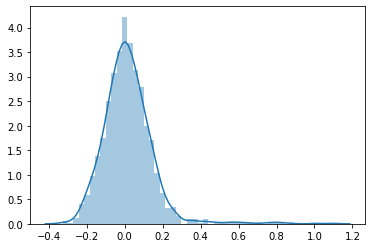

In [7]:
#This is every value in the Noised Galaxy image, the large Gaussian is our random Noise and the right leaning tail
#are the measurments we wish to localize, our actual galaxy
sea.distplot(np.ravel(NIMG))

In [8]:
#0.3 seems to be the point where the noise differs from the galaxy so we will be attempting to 
#find the std of the noise (everything below 0.3)
RIMG = np.ravel(NIMG)
std = np.std(RIMG[RIMG < 0.3])
print('The measured standard deviation we recieved from this method is: ' + str(round(std,5)))

The measured standard deviation we recieved from this method is: 0.10364


Now we will do the same for our actual data. We will also be increasing the scale of the plots and removing the segmentation map from the merger images we identified. We are doing this to see if the brightest pixel alines in place with any other object within frame.

/Users/felixmartinez/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


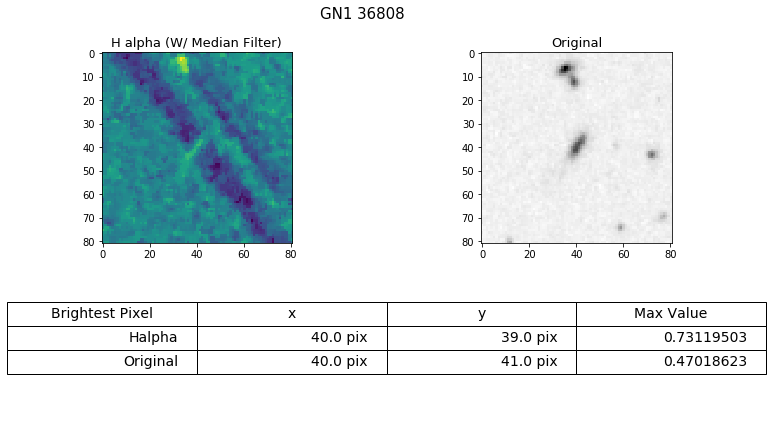

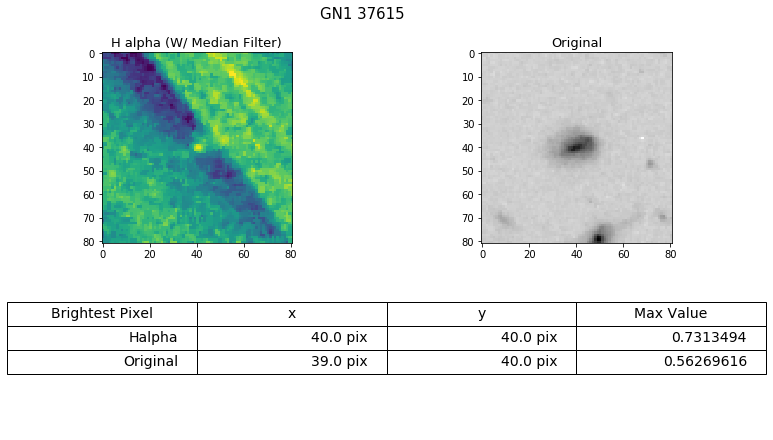

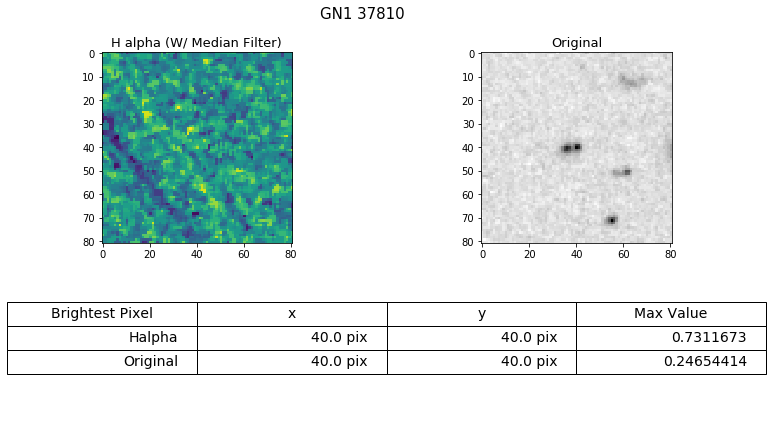

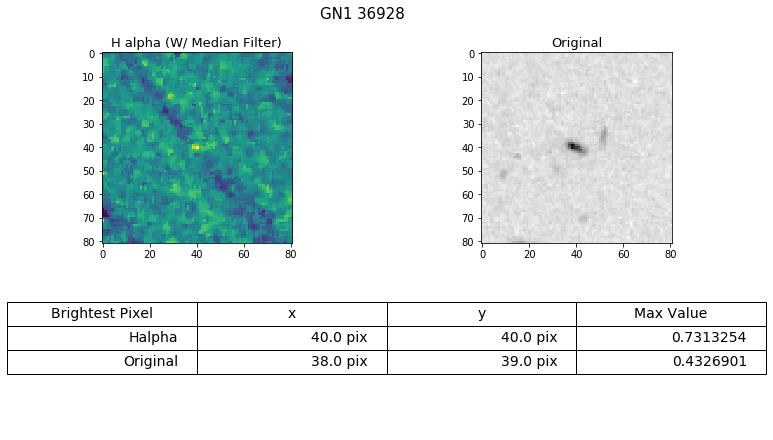

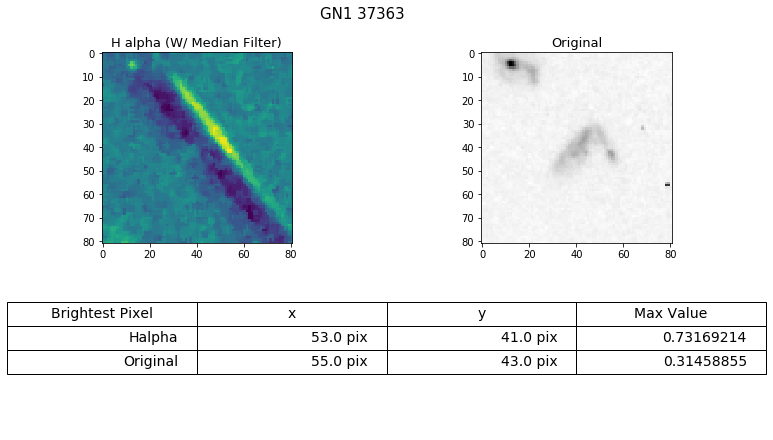

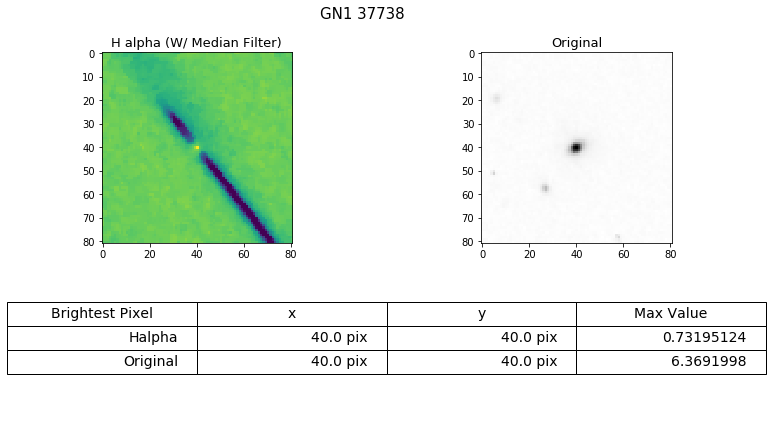

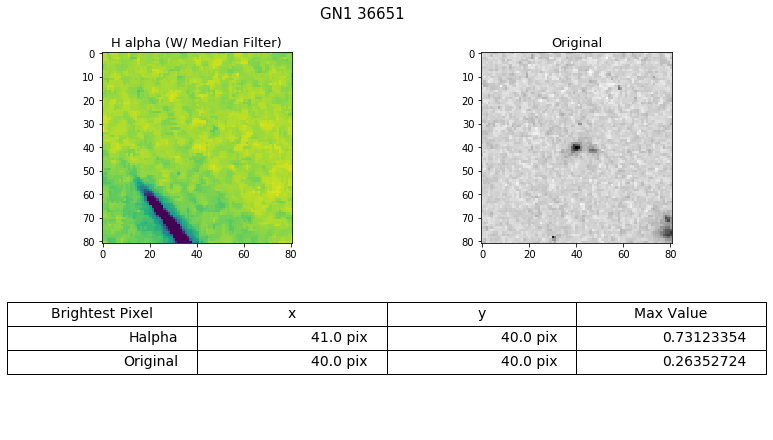

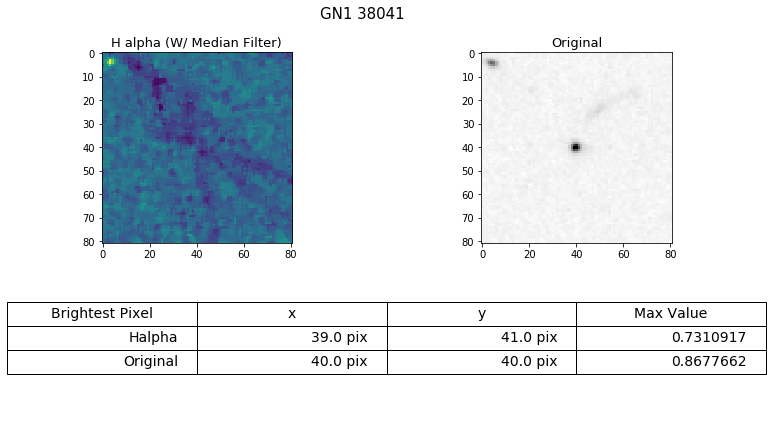

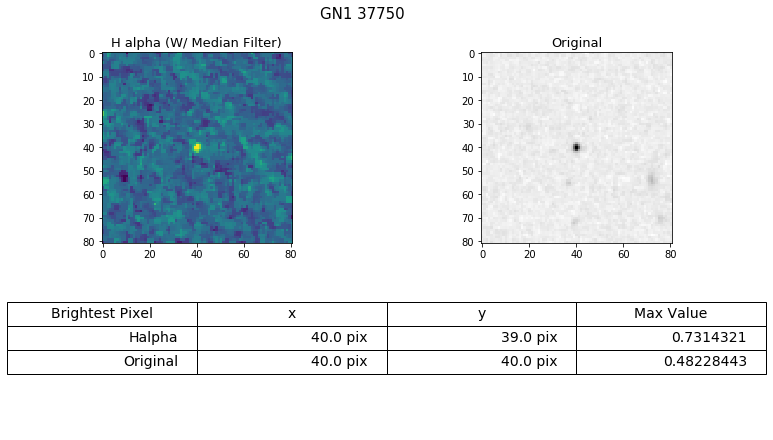

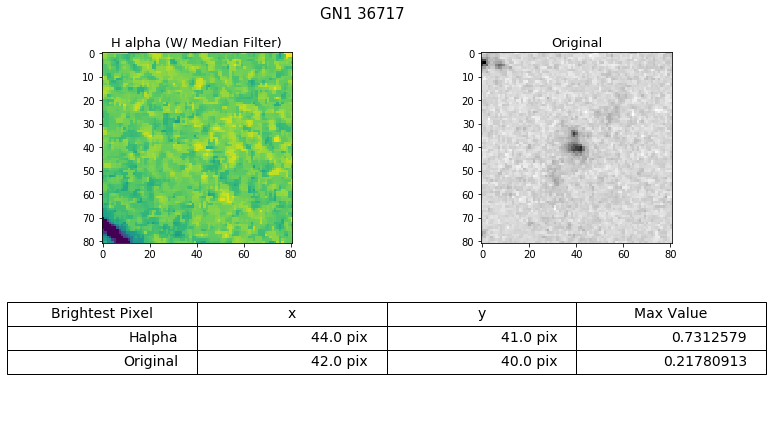

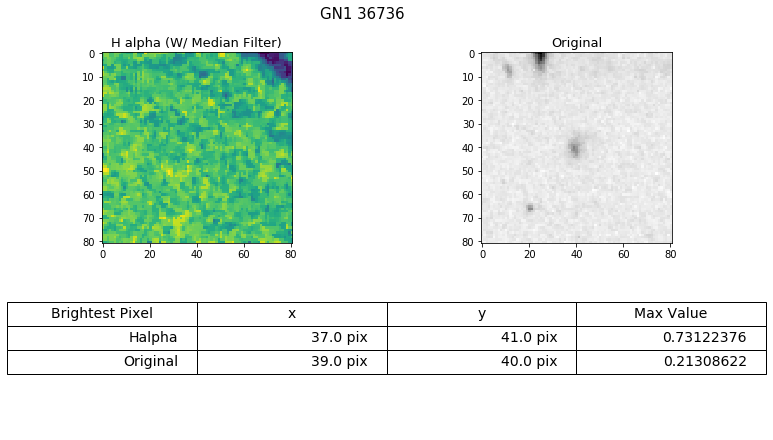

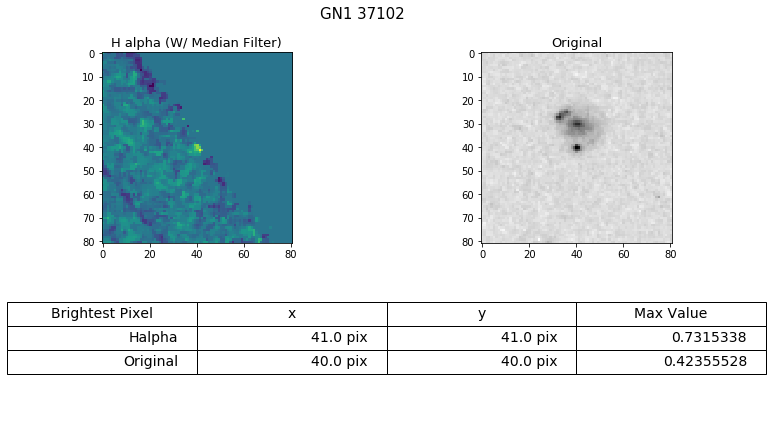

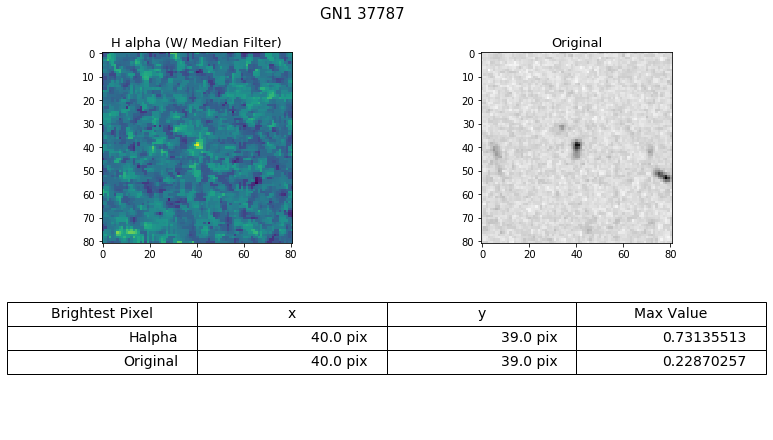

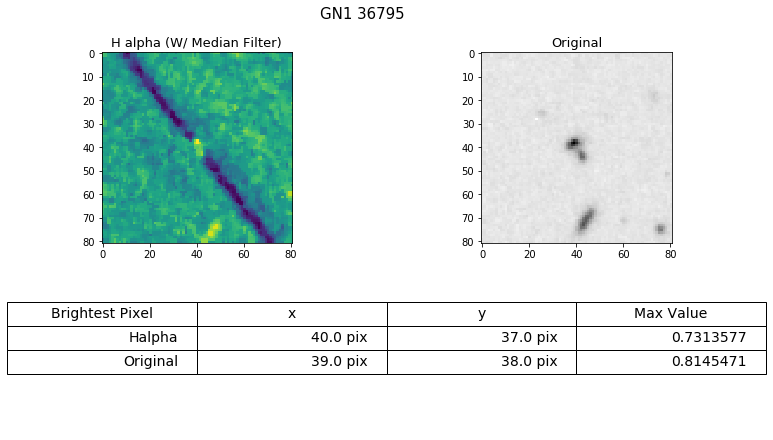

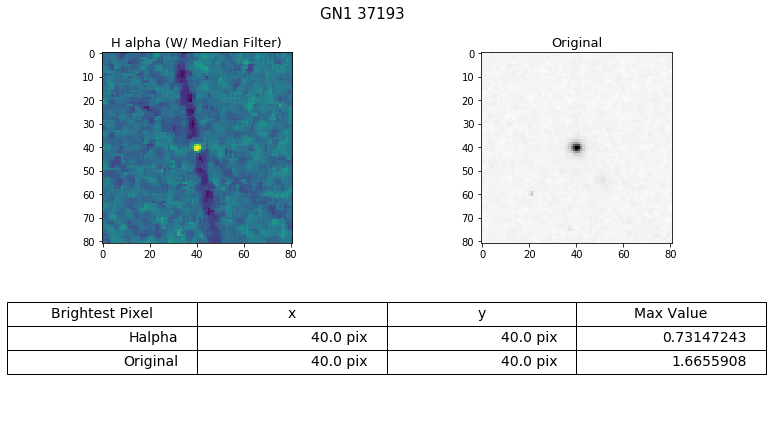

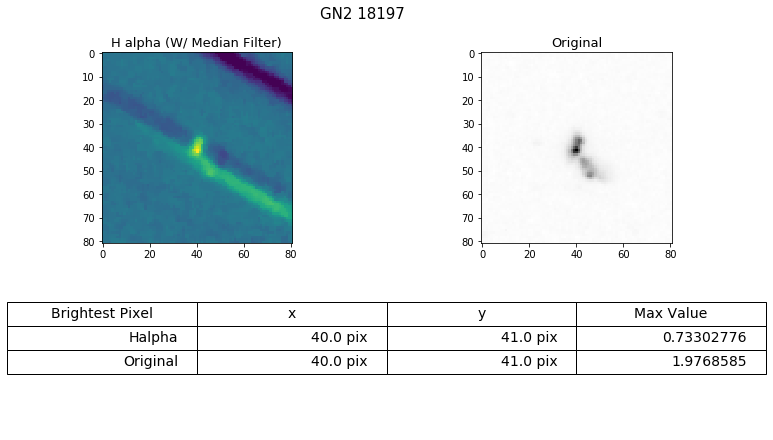

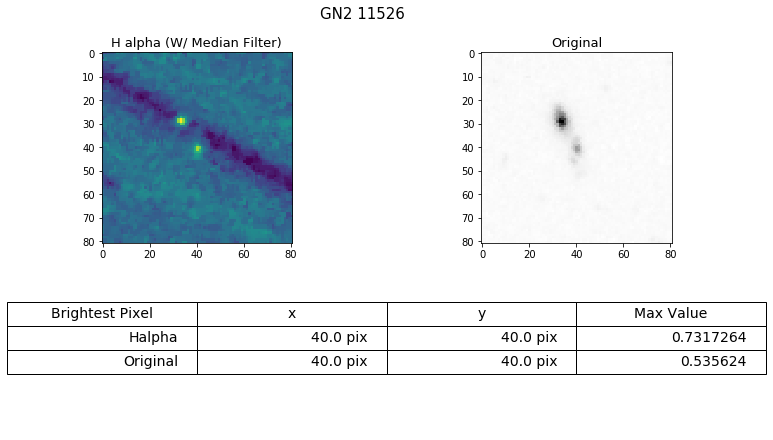

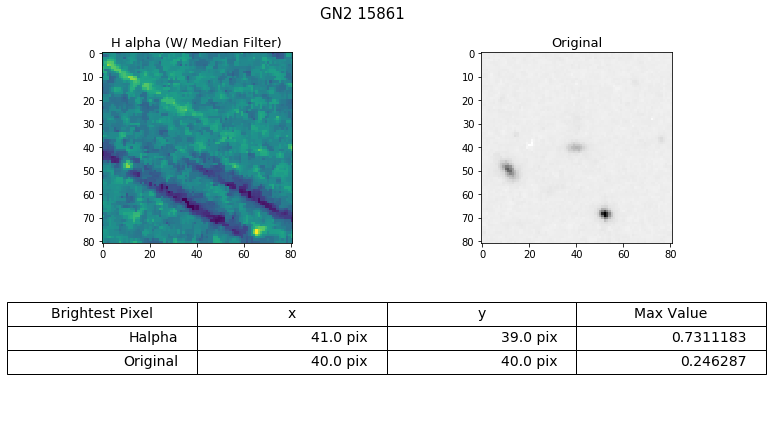

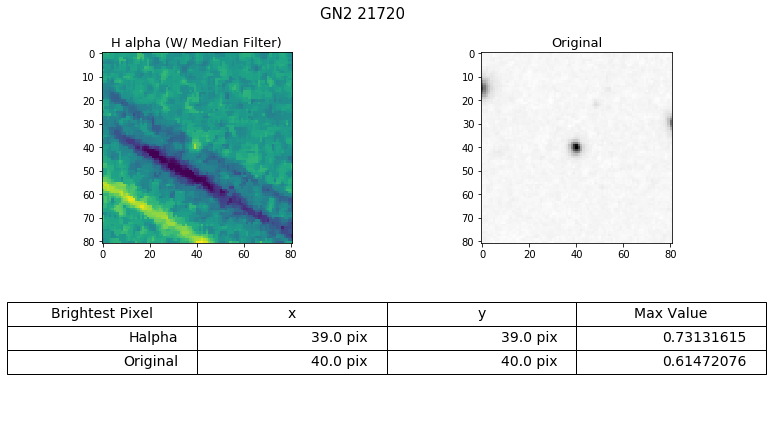

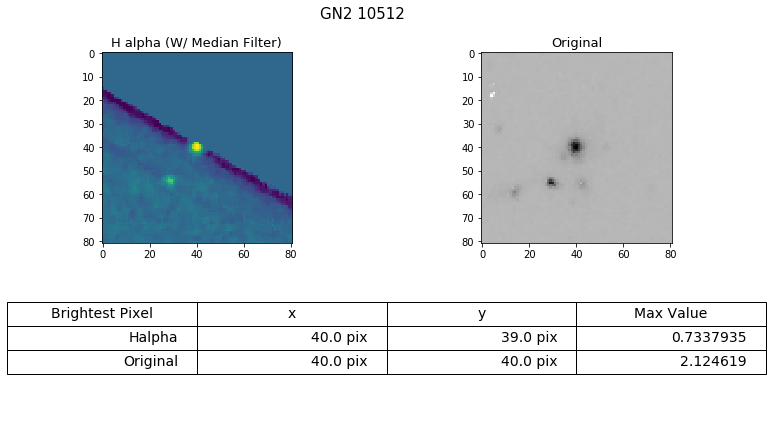

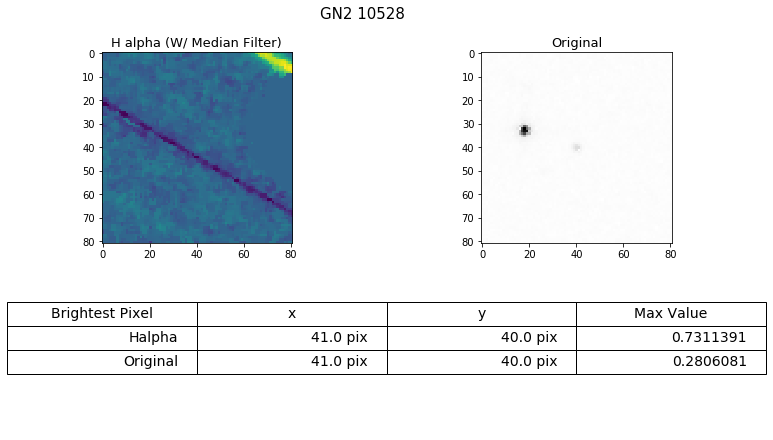

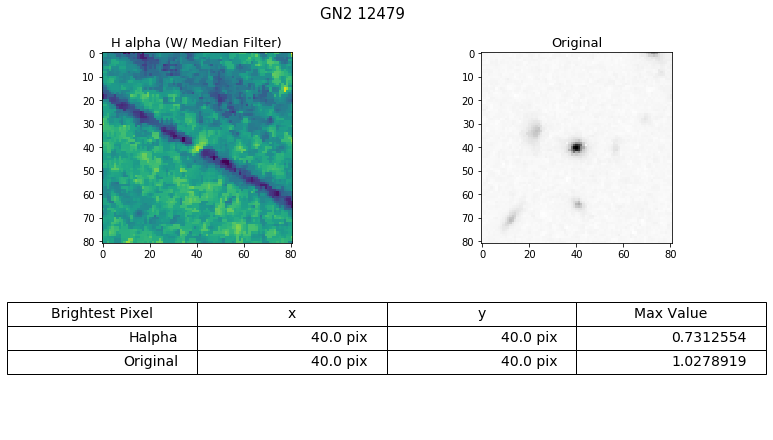

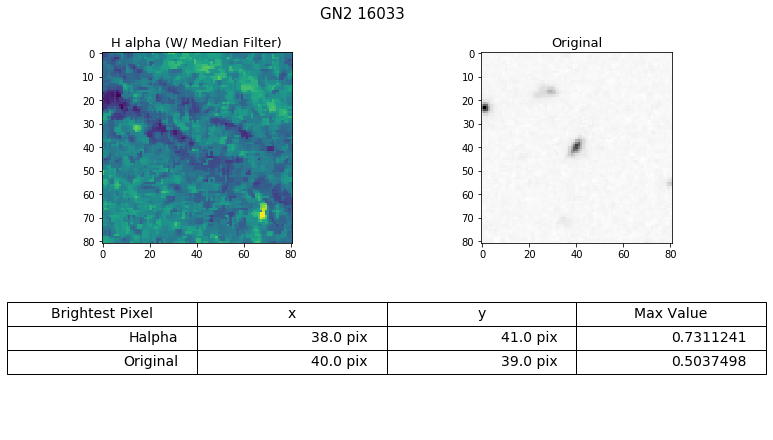

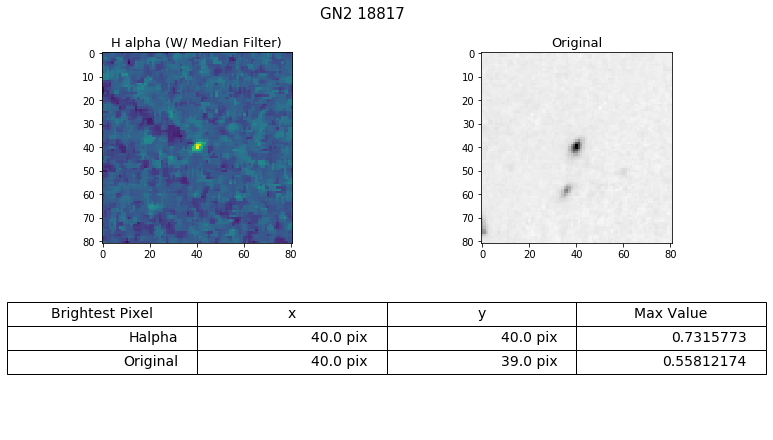

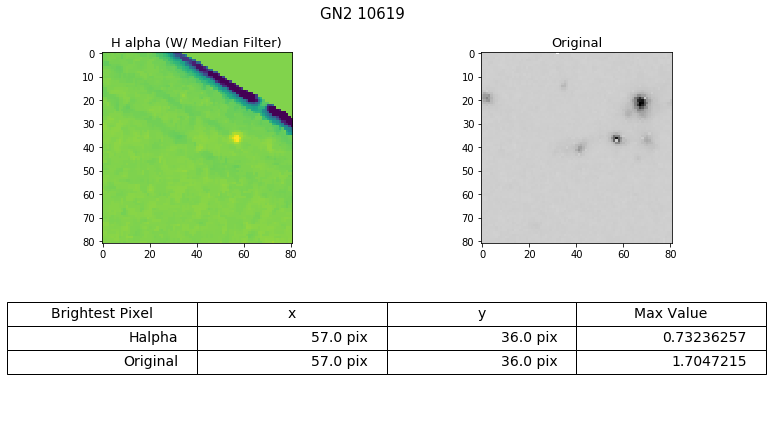

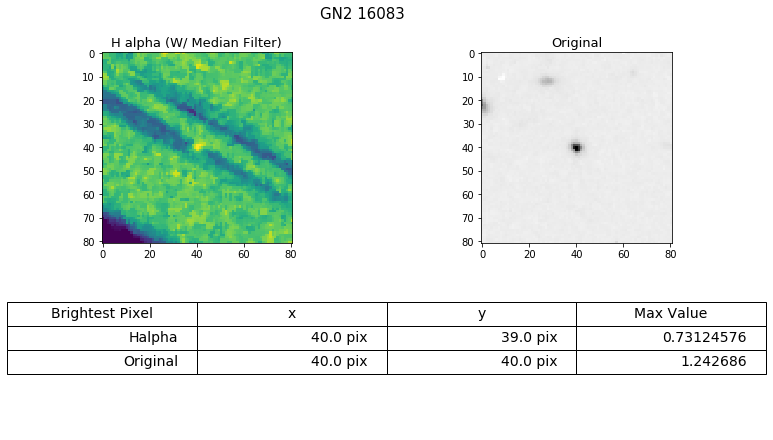

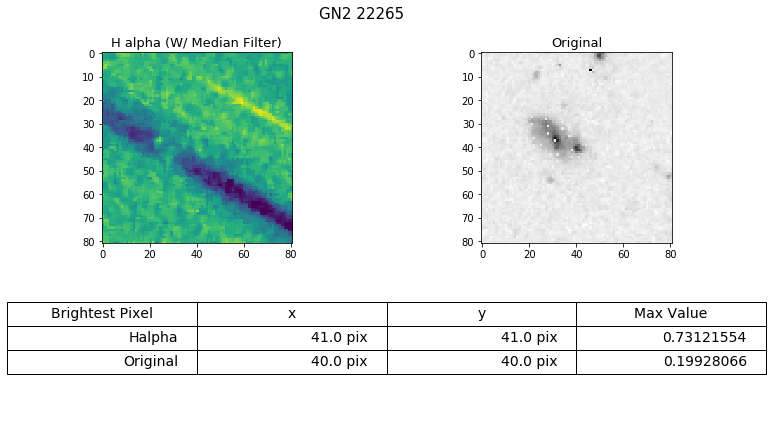

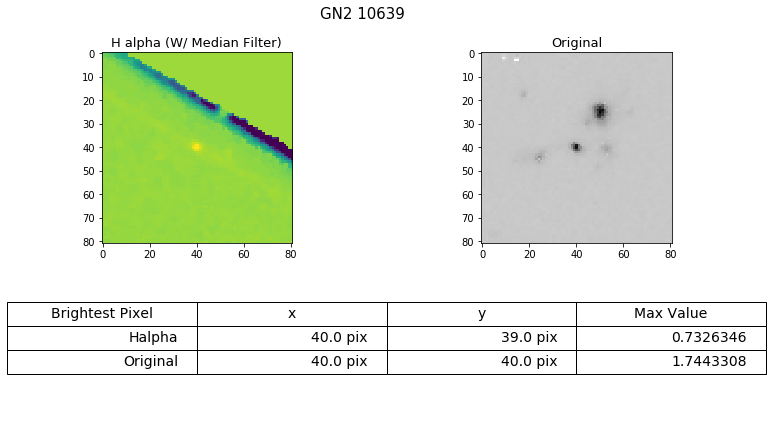

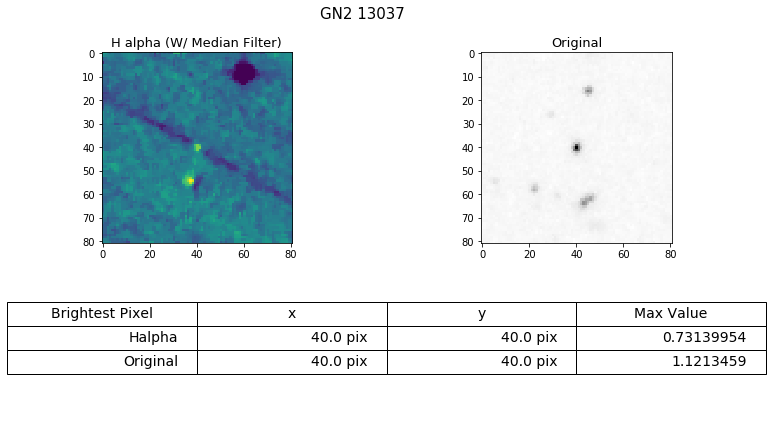

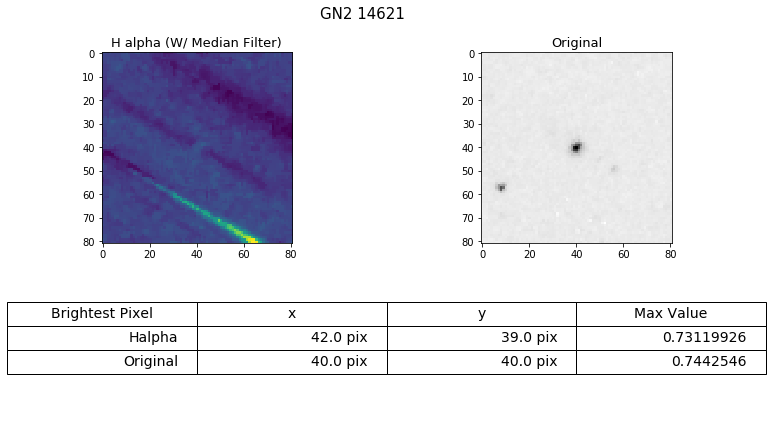

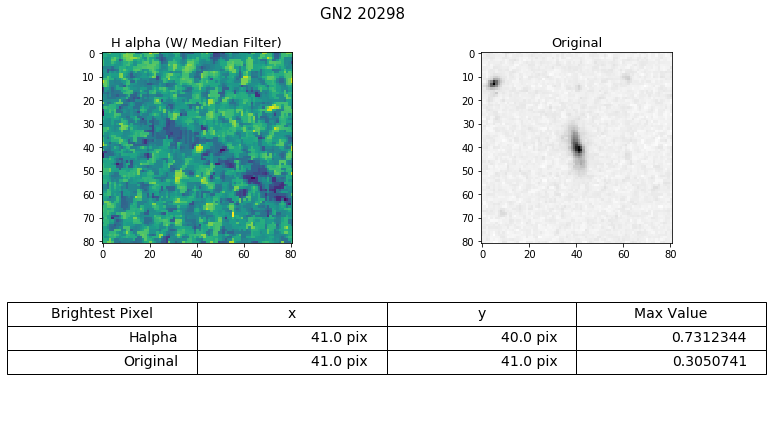

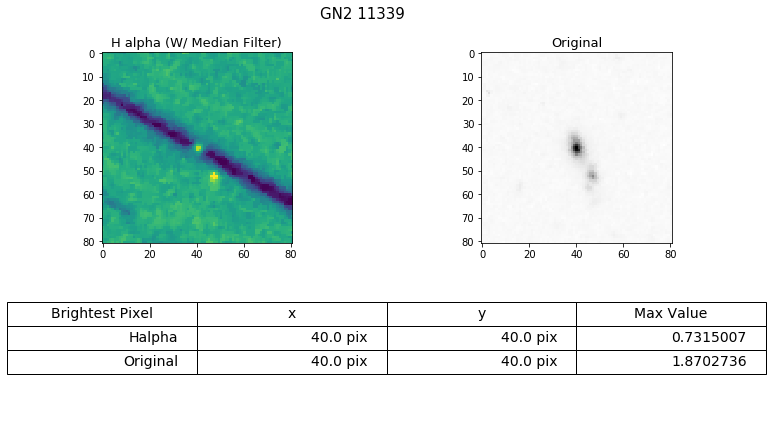

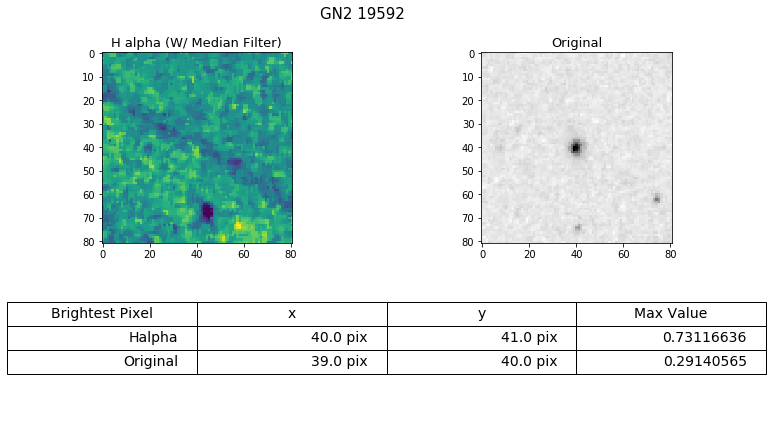

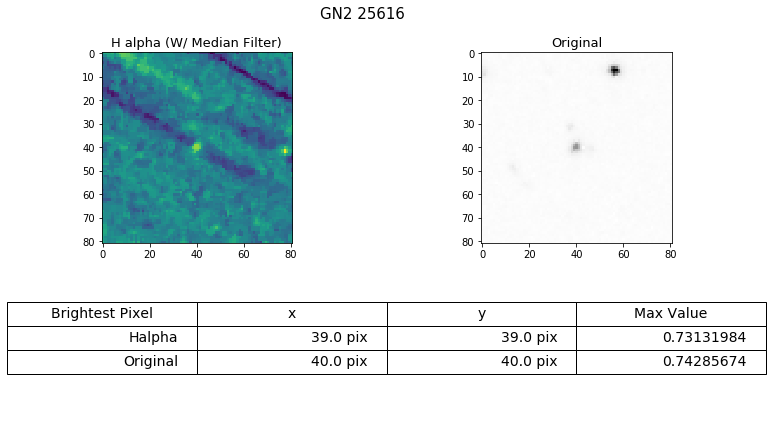

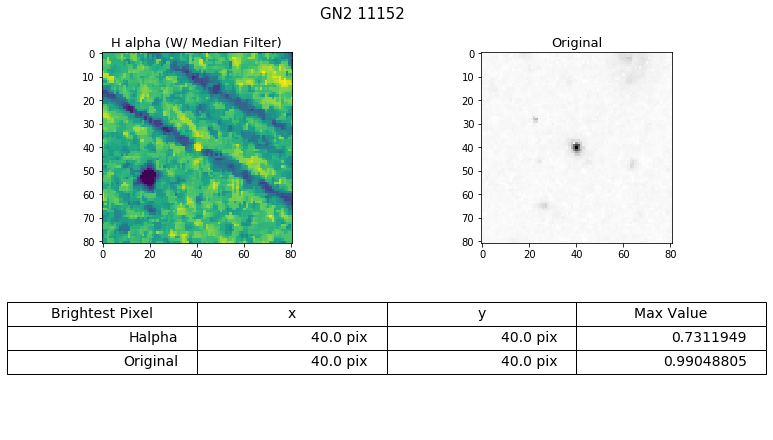

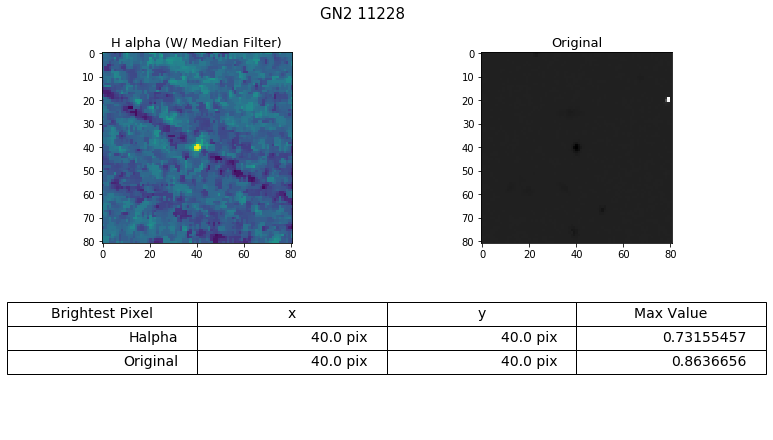

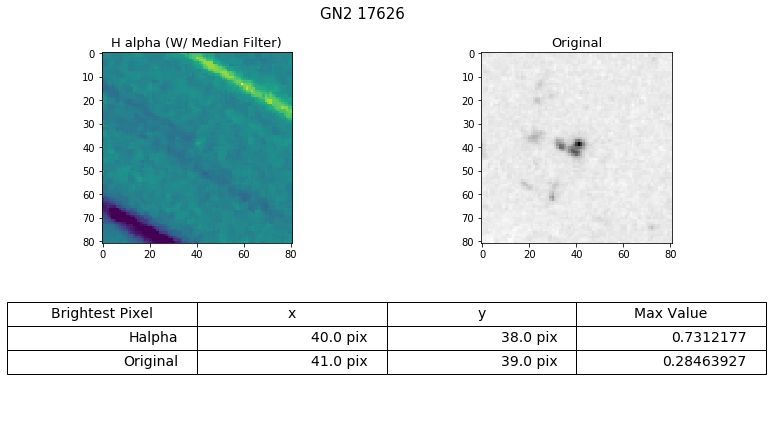

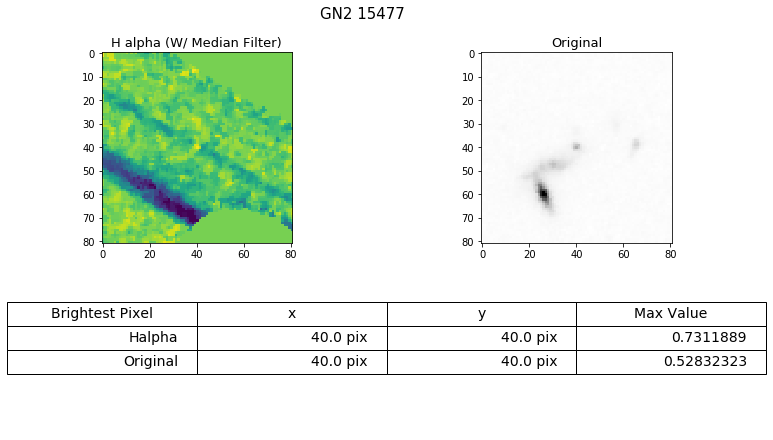

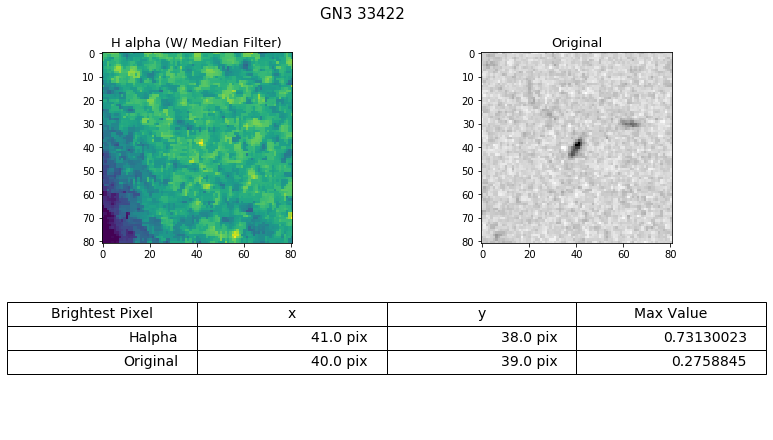

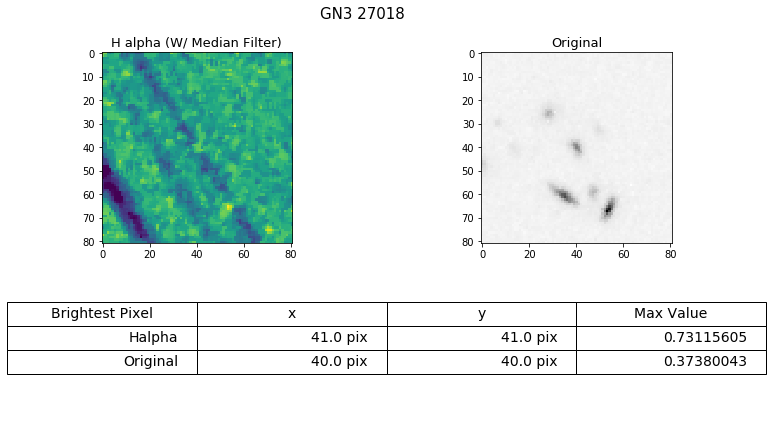

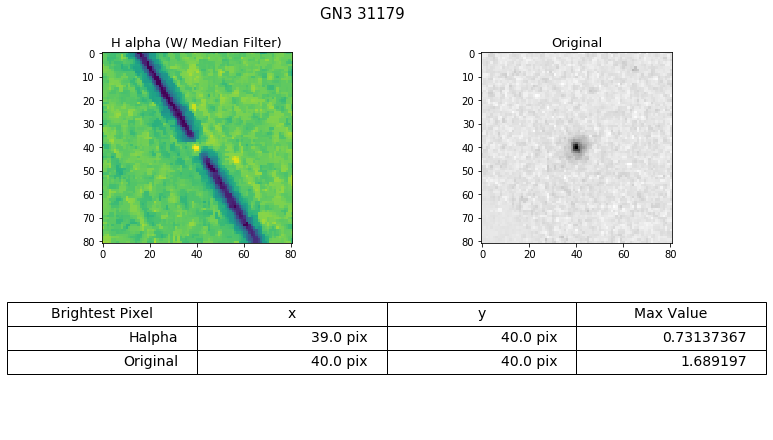

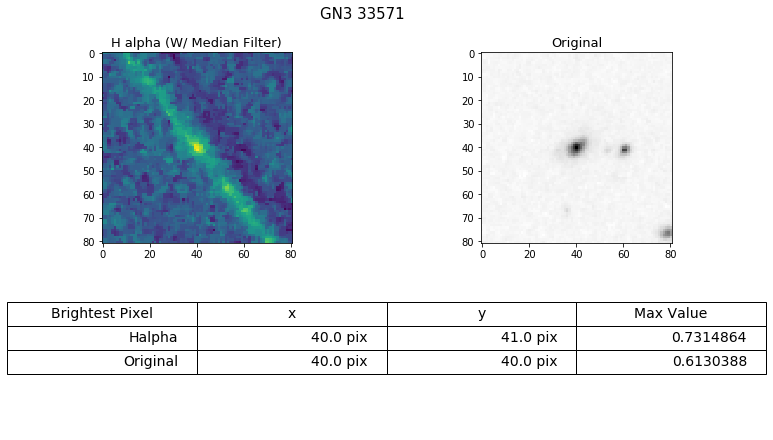

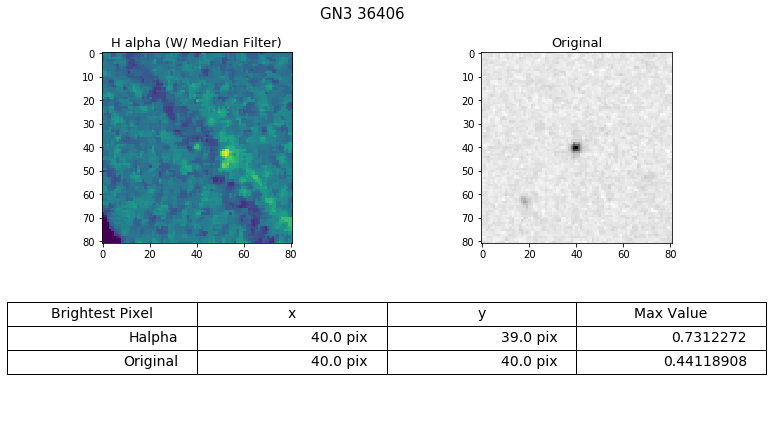

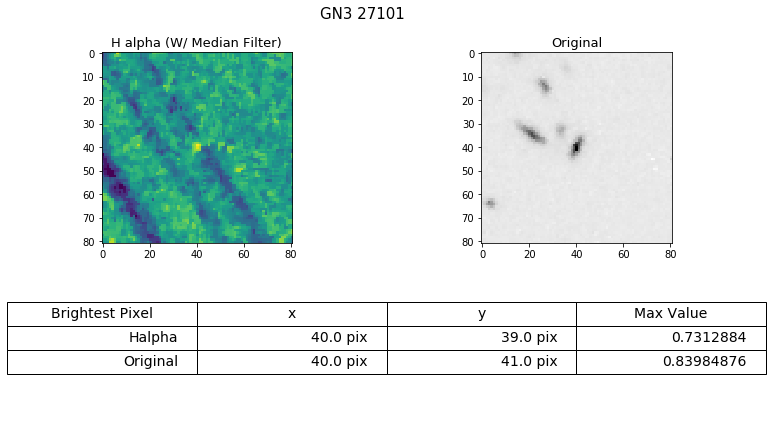

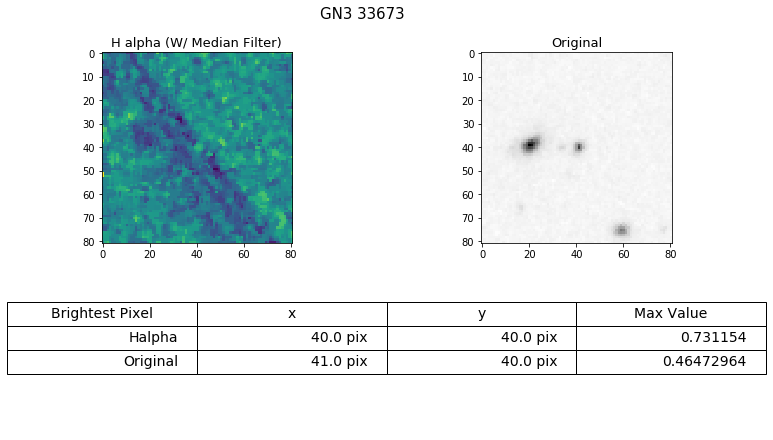

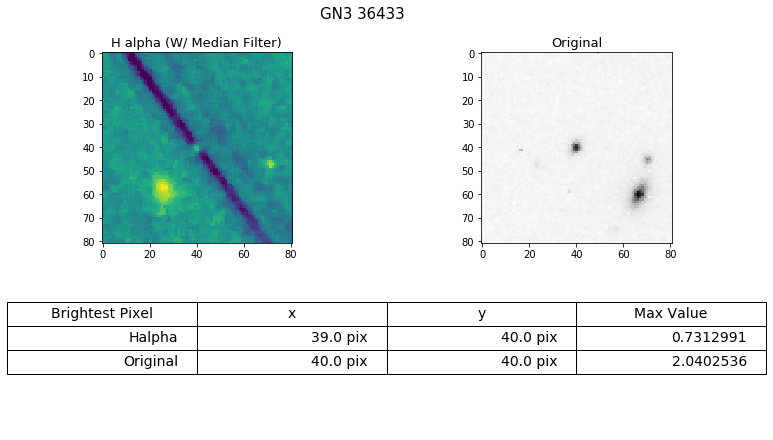

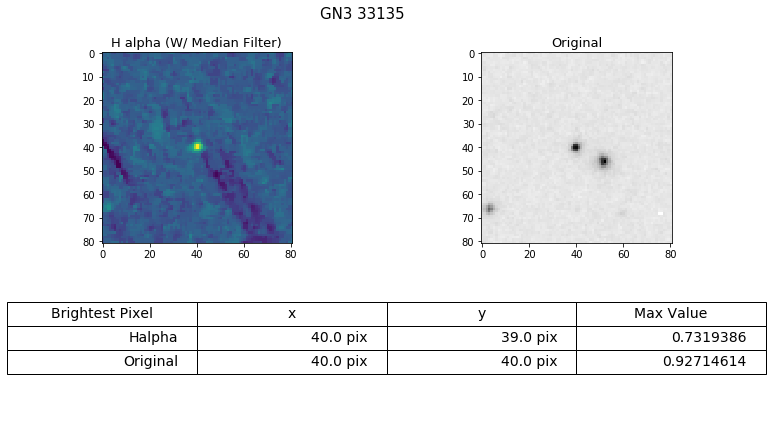

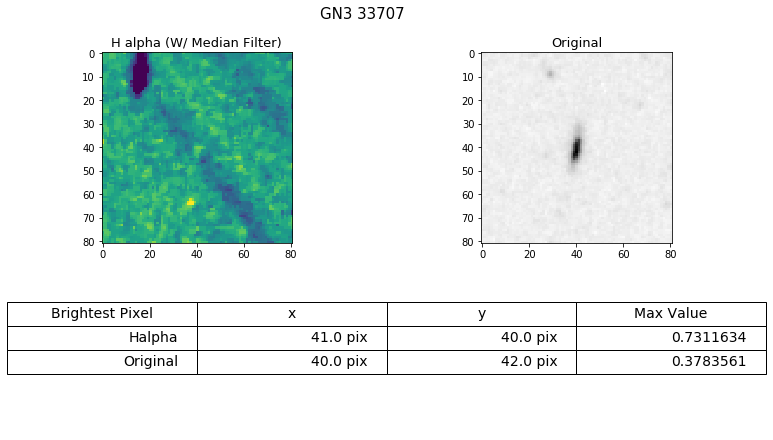

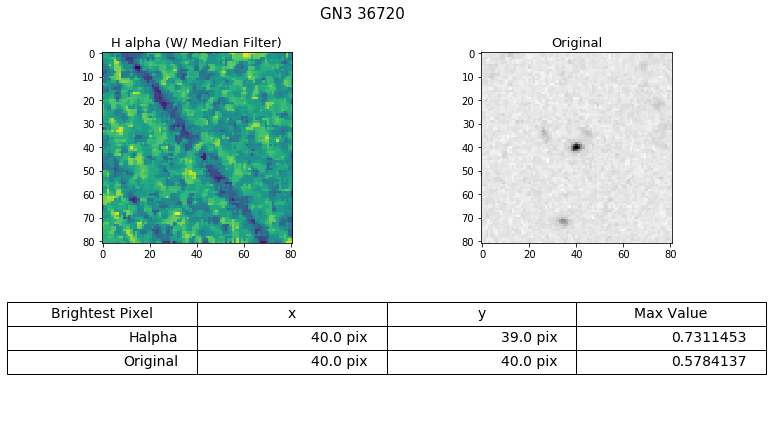

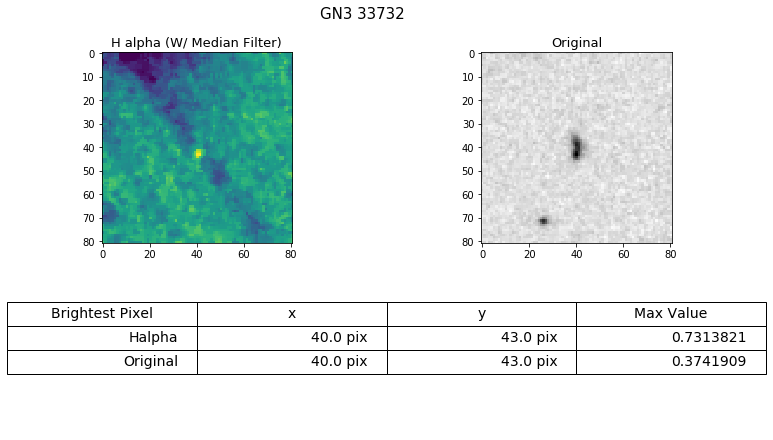

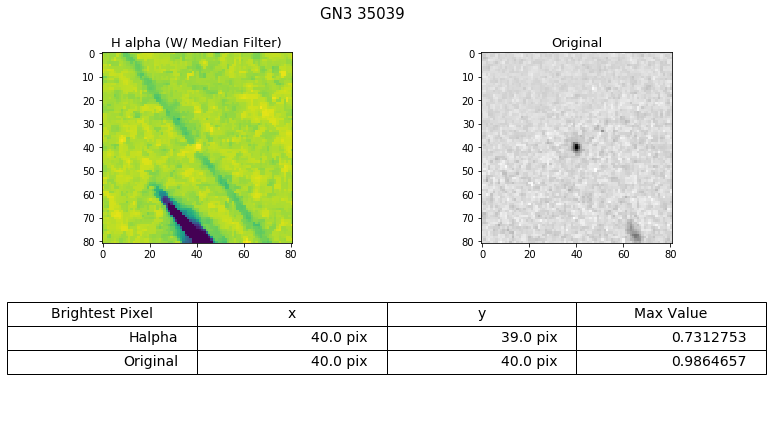

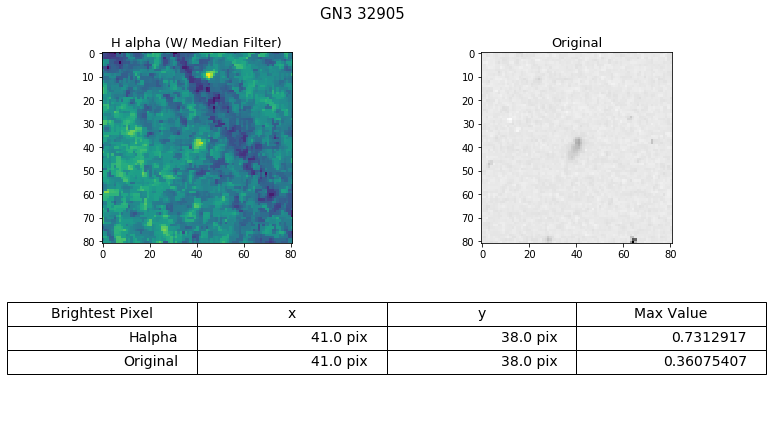

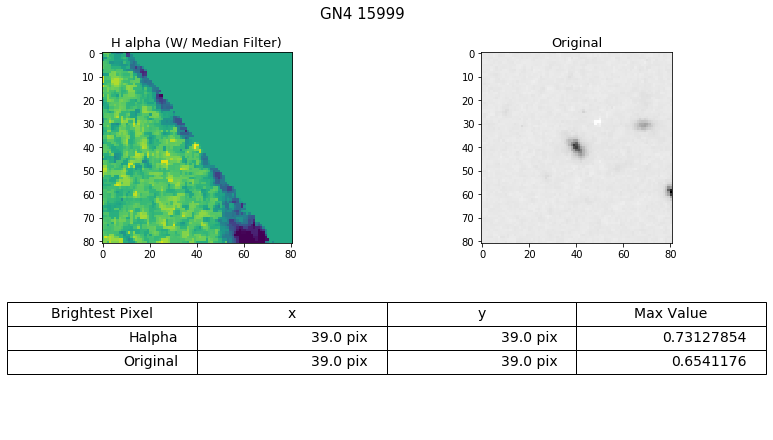

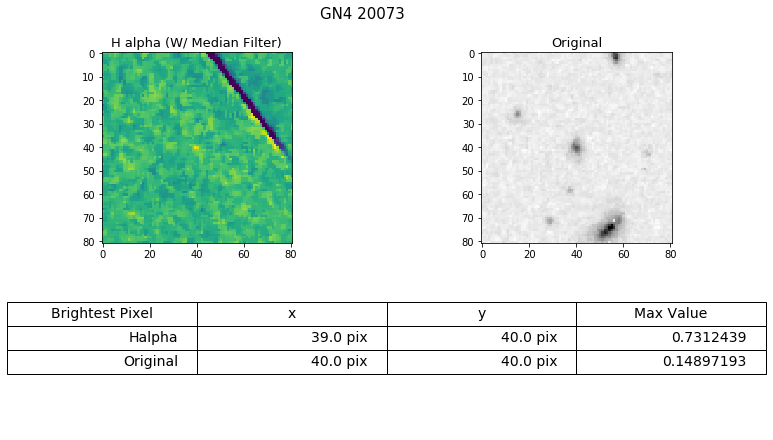

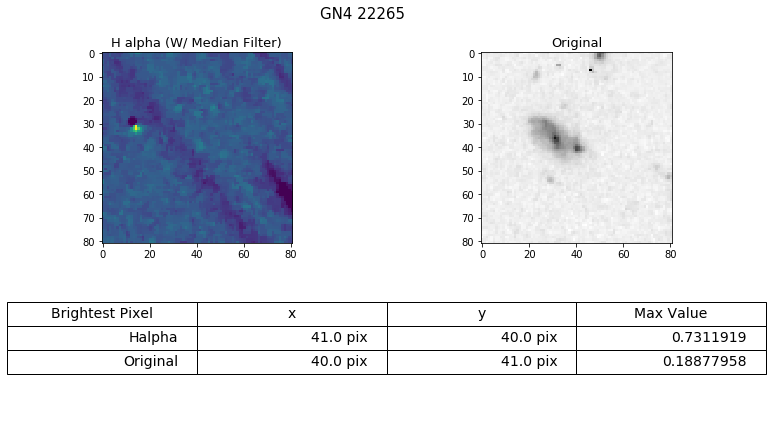

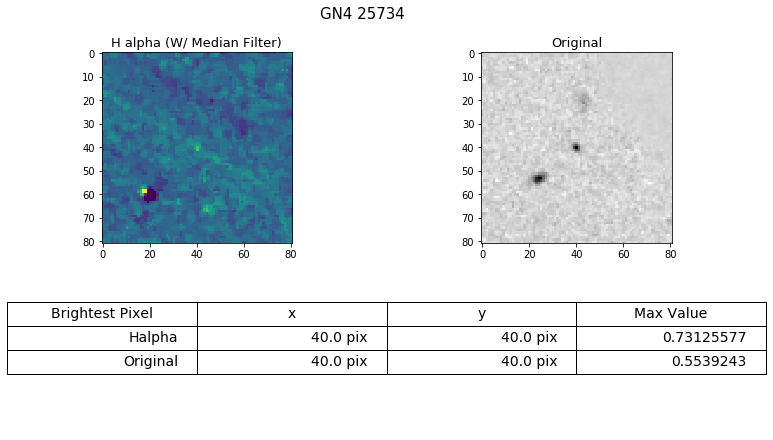

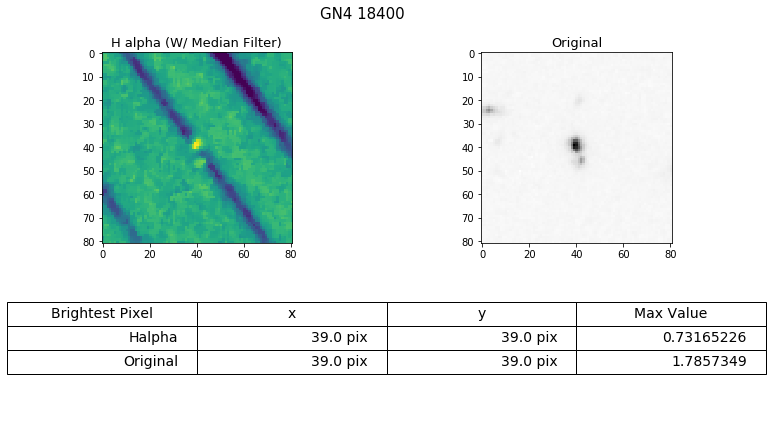

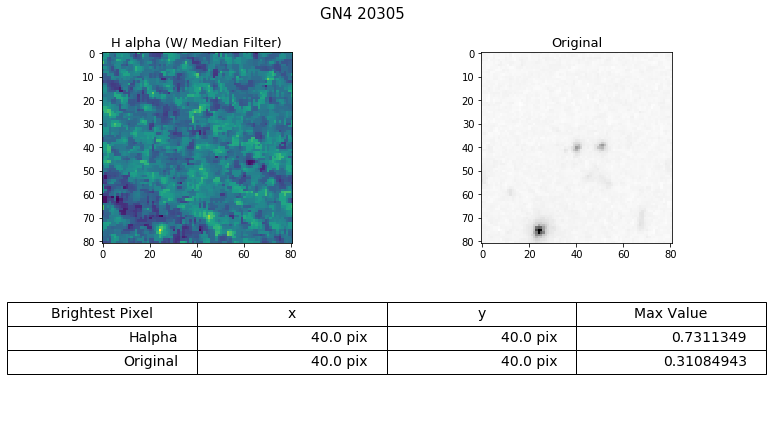

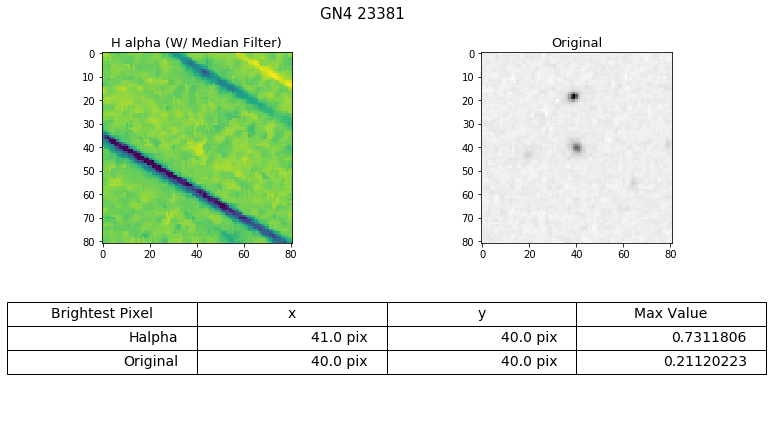

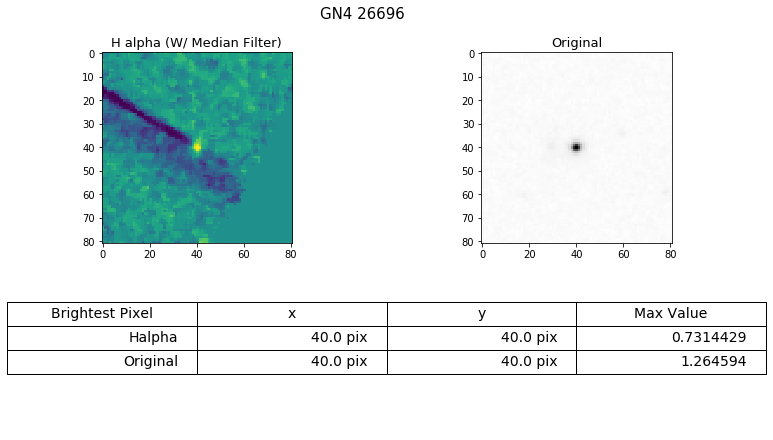

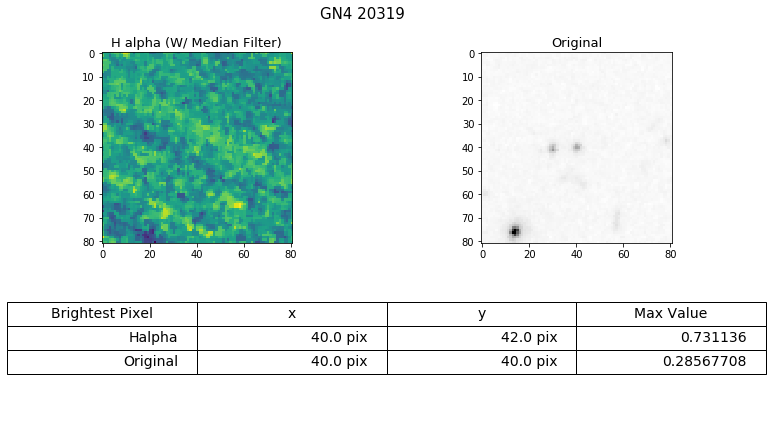

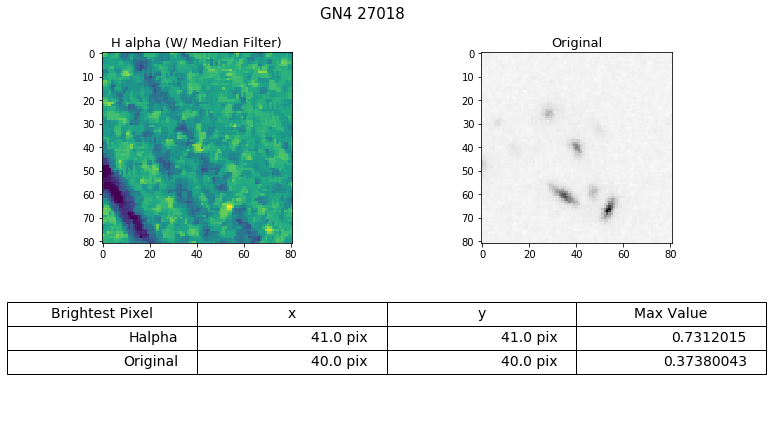

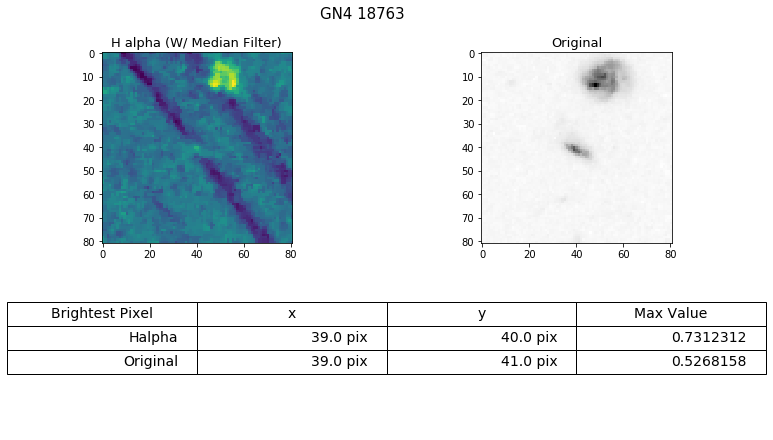

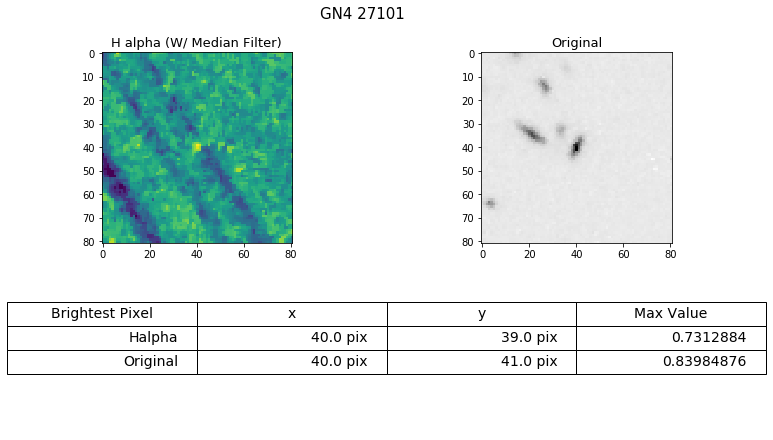

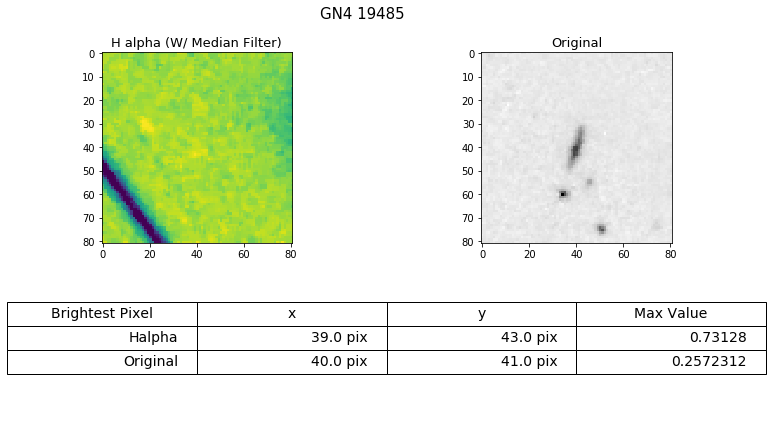

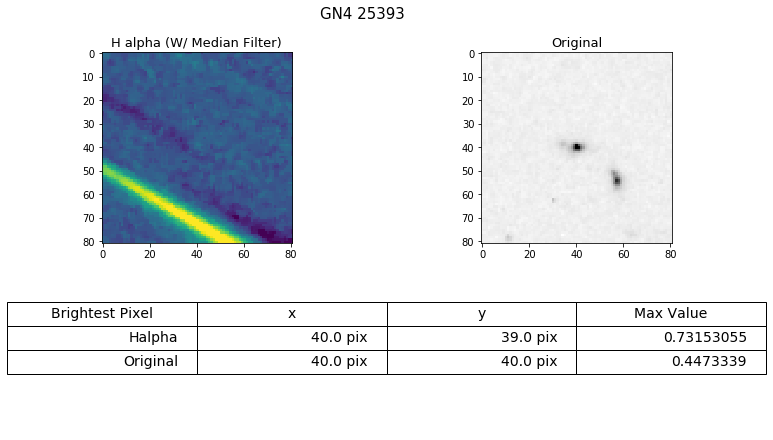

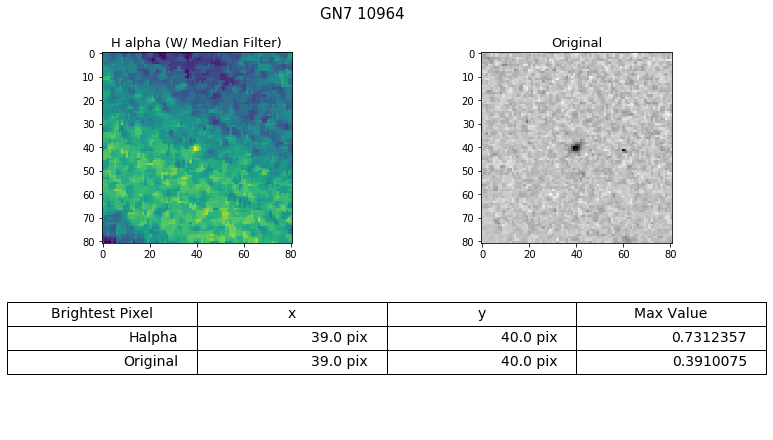

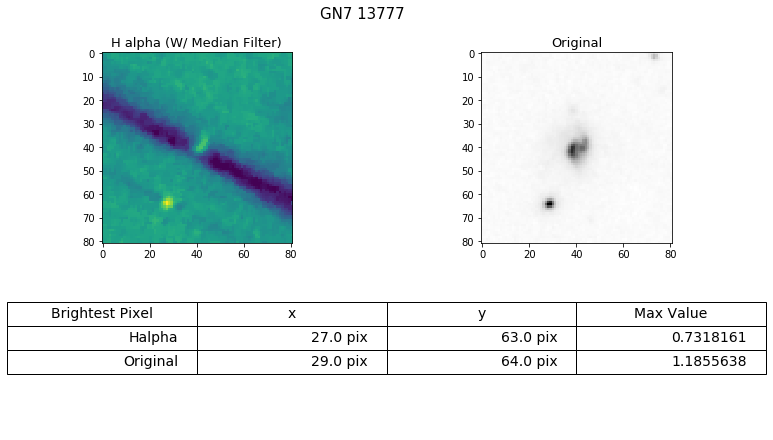

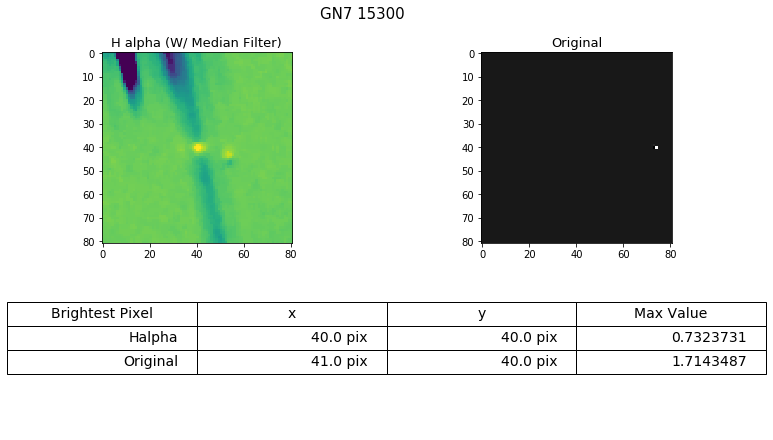

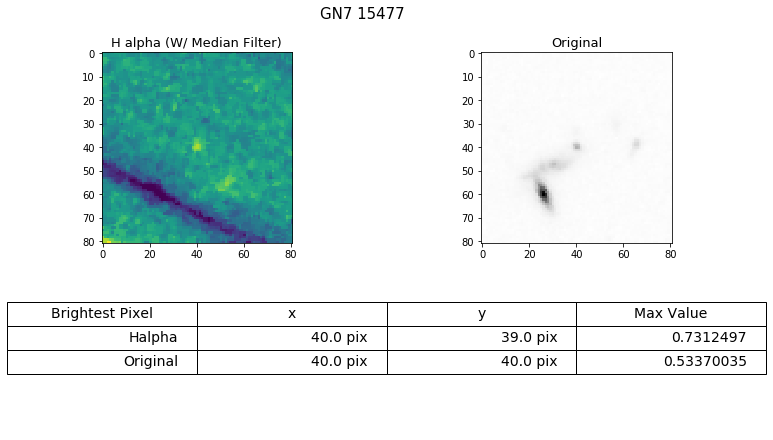

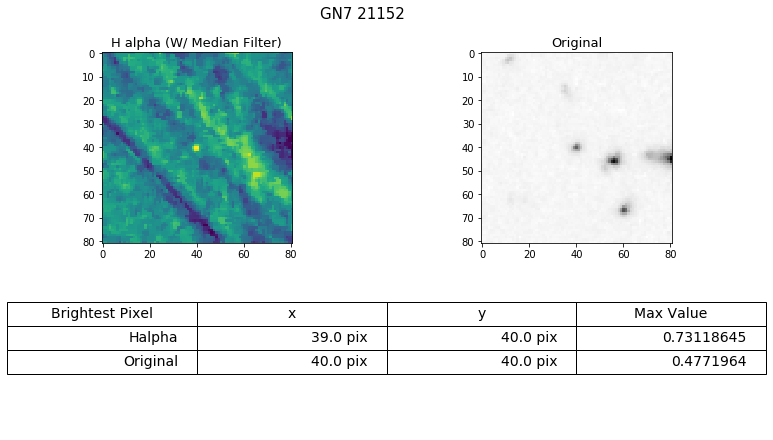

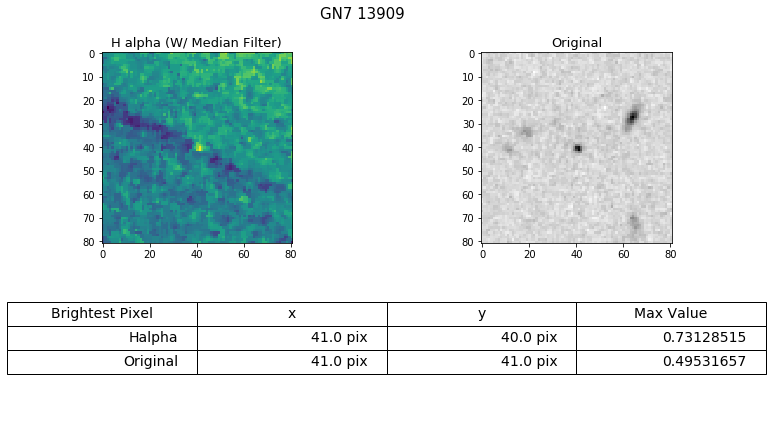

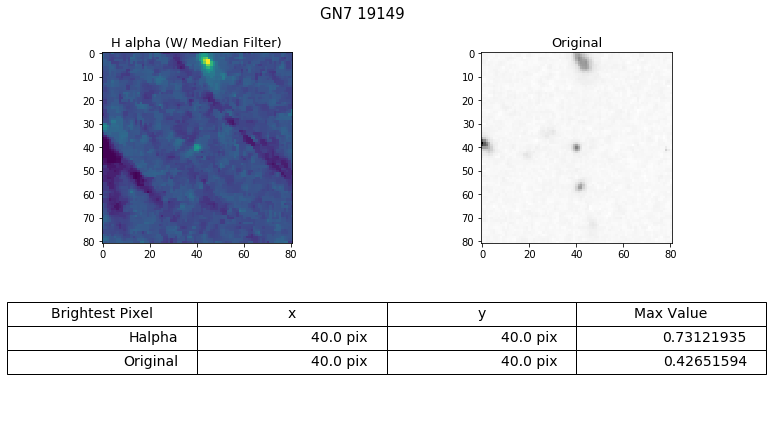

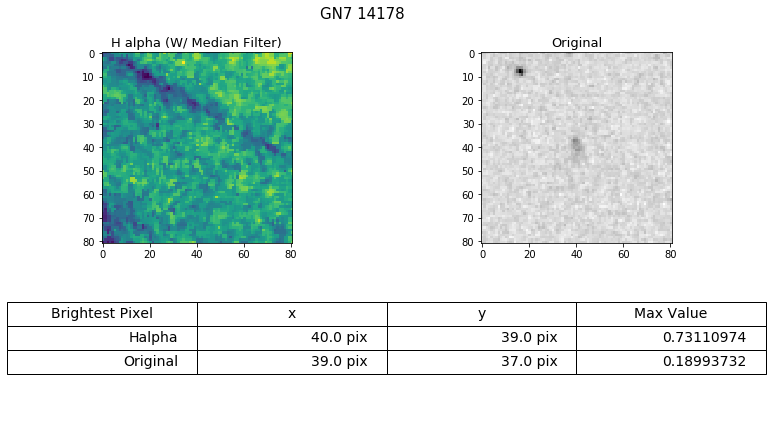

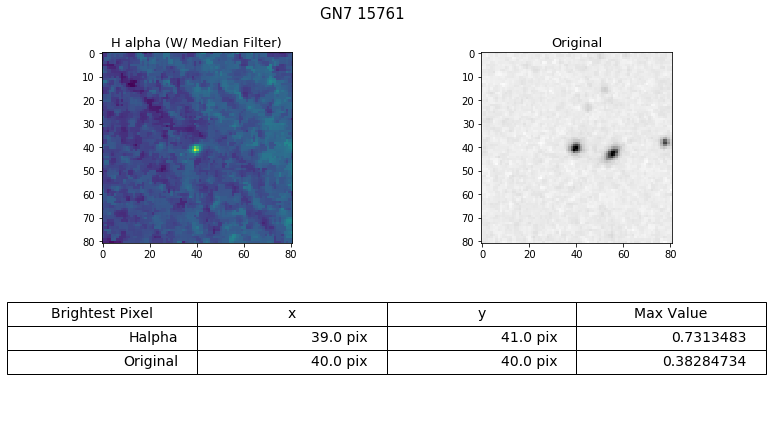

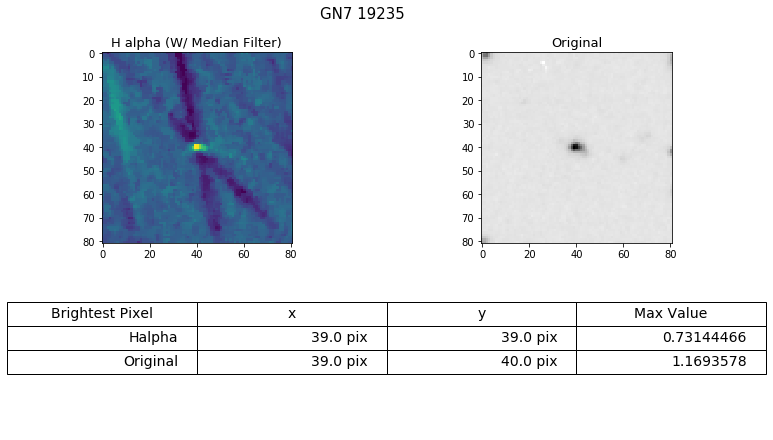

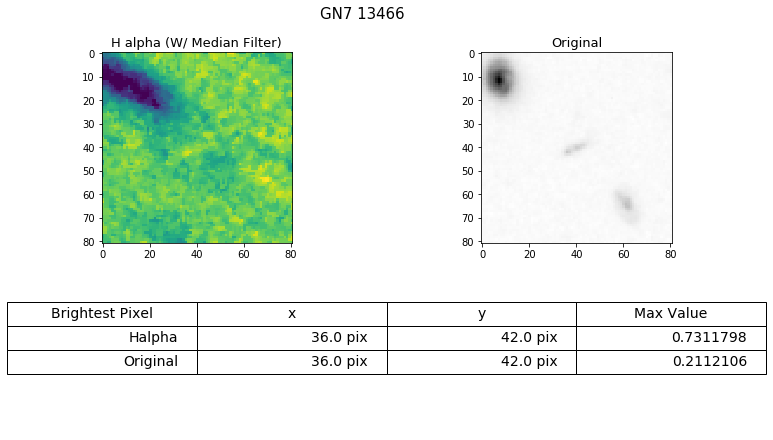

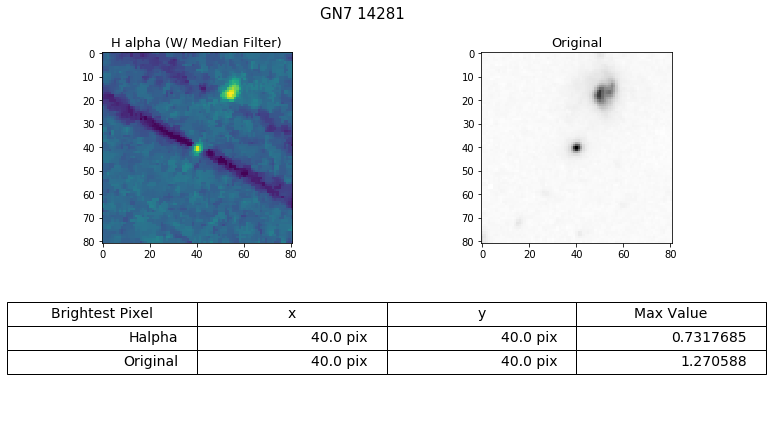

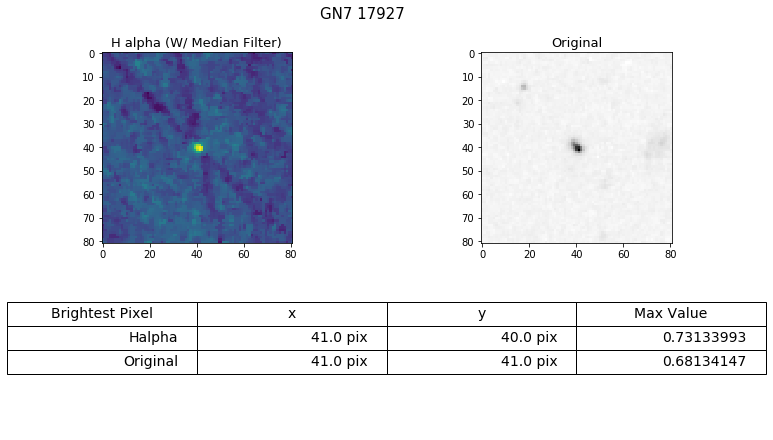

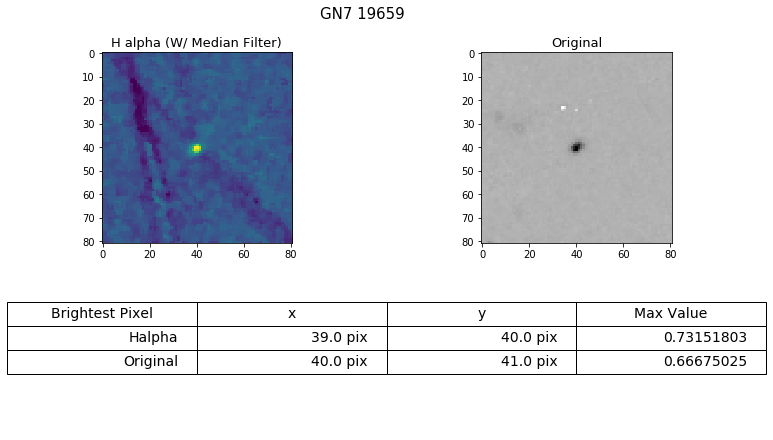

In [13]:
#Finalized Mergers
Sec = [GN1,GN2,GN3,GN4,GN5,GN7]
#Mergers W/ Issues
#Sec = [GN1_bad,GN2_bad,GN3_bad,GN4_bad,GN5_bad,GN7_bad]
Sec_name = ['GN1','GN2','GN3','GN4','GN5','GN7']

GN1_x_off,GN1_y_off,GN2_x_off,GN2_y_off,GN3_x_off,GN3_y_off = [],[],[],[],[],[]
GN4_x_off,GN4_y_off,GN5_x_off,GN5_y_off,GN7_x_off,GN7_y_off = [],[],[],[],[],[]
Std_Title = []
Max_Orig = []
Max_Ha = []
Gal_Orig = []
Gal_Ha = []
Field = []
ID = []

for i in range(len(Sec_name)):
#Listing all the Arrays for Each Section i.e. GN1
    RealData = []
    Mask = []
    im_med = []
    Halph = []
    Orig = []
    Title_fancy = []
    Title_save = []
    Ha_x = []
    Ha_y = []
    Orig_x = []
    Orig_y = []
    PlotData = []
    Plot_img = []
    Orig_plot = []
    
    for j in range(len(Sec[i])):
        GID = Sec[i][j]
        loc = Sec_name[i]
        
#Opening all the Fits Files
        H_a = fits.open('/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/'+loc+'/'+loc+'_'+str(GID)+
                                                                                                '.full.fits')
        Ha_fits = '/Users/felixmartinez/Research/merger_detection/candidates/merger_candidates/'+loc+'/'+loc+'_'+str(GID)+'.full.fits'
        Line = H_a['Line','Ha'].data     #Halpha data
        Continuum = H_a['Continuum','Ha'].data
        Contam = H_a['Contam','Ha'].data
        Raw = H_a['DSCI','F105W'].data
        
#Cropping and Correcting the data
        #Halph.append(Line[59:100,59:100] - Continuum[59:100,59:100] - Contam[59:100,59:100])  #Fixing the Errors on Halpha
        #Orig.append(Raw[59:100,59:100])
#The data uncropped
        Halph.append(Line[39:120,39:120] - Continuum[39:120,39:120] - Contam[39:120,39:120])  #Fixing the Errors on Halpha
        Orig.append(Raw[39:120,39:120])
        Title_fancy.append(loc + ' ' + str(GID))
        Title_save.append(loc + '_'+str(GID))
        
#X and Y Posistions of Galaxy on Seg Map
        Y,X = np.where(seg_N == GID)
        Z = np.array([Y,X]).T     #Gives the X and Y positions of Object in Y,X
        world = w.wcs_pix2world(Z,1)  #Gives RA and Dec Values of Object (May not be needed)
        
#Center Pixel of Ha on Seg Map
        RA = H_a[0].header['RA']                                
        DEC = H_a[0].header['DEC']    

        center = w.wcs_world2pix([[RA,DEC]],1)   #Finds the center pixels of the central RA and Dec of the Ha cutout
        hy = np.round(center[0][0])
        hx = np.round(center[0][1])
        center = np.array([int(hx),int(hy)])

#Making a Mask that is the Galaxy on Seg Map
        #seg_mask = np.array(seg_N[center[0]-20:center[0]+21,center[1]-20:center[1]+21]) #40x40 seg mask
        #seg_mask = np.array(seg_N[center[0]-30:center[0]+31,center[1]-30:center[1]+31]) #60x60 seg mask
        seg_mask = np.array(seg_N[center[0]-40:center[0]+41,center[1]-40:center[1]+41]) #80x80 seg mask
        seg_mask[seg_mask != GID] = 0
        seg_mask[seg_mask == GID] = 1
    
        Mask.append(np.array(seg_mask))
        
        Ha_img = Halph[j]
        Orig_img = Orig[j]
        
#Applying the Filter for the Galaxy Image
        #Halpha Image
        m=np.percentile(Ha_img,1.5)   #High Pass
        M=np.percentile(Ha_img,98.5)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        PlotData.append(func.scaling_factor(Ha_img, m, M)) #Plotting image
        Plot_img.append(ndimage.median_filter(PlotData[j], size = (3,3)))  #Median smoothing for the plotting of the img
        #Gal_img.append(Plot_img[j])
        
        #Origingal Image
        m=np.percentile(Orig_img,0)   #High Pass
        M=np.percentile(Orig_img,100)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        Orig_plot.append(func.scaling_factor(Orig_img, m, M)) #Plotting image
        
#Applying the Segmentation Map Mask
        Ha_img[Mask[j] == 0]= -99
        Orig_img[Mask[j] == 0]= -99
        
#Applying the Filter for the Segmentation Map
        m=np.percentile(Ha_img,1.5)   #High Pass
        M=np.percentile(Ha_img,98.5)  #Low Pass
        if M < np.abs(m)*6:
            M = np.abs(m)*6
        RealData.append(func.scaling_factor(Ha_img, m, M))  #brightest pixel Real
        #im_med.append(Scaling_factor(Ha_img, m, M))  #brightest pixel Fake
        im_med.append(ndimage.median_filter(RealData[j], size = (3,3)))  #Median Smoothing for finding the pixel
        
#Finding the Position of the Brightest Pixel and its value
        Ha_position = np.argwhere(im_med[j] == im_med[j].max()) * u.pixel
        Ha_max_value = np.amax(im_med[j])

        Orig_position = np.argwhere(Orig_img == Orig_img.max()) * u.pixel
        Orig_max_value = np.amax(Orig_img) 
        
#Appending the x and y for the Histogram
        Ha_x.append(Ha_position[0][1])
        Ha_y.append(Ha_position[0][0])
        Orig_x.append(Orig_position[0][1])
        Orig_y.append(Orig_position[0][0])
        
#Filtering out Galaxies that are not within the inner 68%
        diff_x = Ha_x[j].value - Orig_x[j].value
        diff_y = Ha_y[j].value - Orig_y[j].value
        
        #if(round(xrange[x_low_3[0]],1) <= diff_x <= round(xrange[x_high_3[0]],1) and   #Within 3 Standard Deviations
        #   -2.5 <= diff_y <= round(xrange[y_high_3[0]],1)):
        if(-2.5 <= diff_x <= 2.5 and -2.5 <= diff_y <= 2.5):   #Within 3 Standard Deviations
            
            Gal_Ha.append(Ha_img)                    #H-alpha Values within 3 std
            Gal_Orig.append(Orig_img)                #Original Values within 3 std
            Std_Title.append(loc + ' ' + str(GID))   #Names of Gal within 3 std
            Max_Orig.append(Orig_max_value)          #Max original values within 3 std
            Max_Ha.append(Ha_max_value)              #Max Ha values within 3 std
            Field.append(loc)                        #Appending the location
            ID.append(GID)                           #Appending the Galaxy ID
            
#Appending the x and y offset Separetly by Section
            if loc == 'GN1':
                GN1_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN1_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN2':
                GN2_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN2_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN3':
                GN3_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN3_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN4':
                GN4_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN4_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN5':
                GN5_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN5_y_off.append(Ha_y[j].value - Orig_y[j].value)
            if loc == 'GN7':
                GN7_x_off.append(Ha_x[j].value - Orig_x[j].value)
                GN7_y_off.append(Ha_y[j].value - Orig_y[j].value)
            
        
#Making a table with Information of the Pixels location and values
            Test = {'Ha_x':pd.Series(Ha_position[0][1]), 'Ha_y':pd.Series(Ha_position[0][0]),
                    'Ha_max_value':pd.Series(Ha_max_value),'Orig_x':pd.Series(Orig_position[0][1]),
                    'Orig_y':pd.Series(Orig_position[0][0]),'Orig_max_value':pd.Series(Orig_max_value)}
            Position_table = pd.DataFrame(Test)    
            table_data=[['Halpha',Ha_position[0][1],Ha_position[0][0],Ha_max_value],
                        ['Original',Orig_position[0][1],Orig_position[0][0],Orig_max_value]]
        
#Plotting the Figures
            Labels=['Brightest Pixel','x','y','Max Value']
    
            plt.figure(figsize=[17,7])
            gs = GridSpec(2,4, wspace = -.499, hspace=0)
    
            plt.subplot(gs[0,1])    #Halpha Image
            plt.title('H alpha (W/ Median Filter)',fontsize = 13)
            plt.imshow(Plot_img[j])

            plt.subplot(gs[0,3])    #Original Image
            plt.title('Original',fontsize = 13)
            plt.imshow(Orig_plot[j],cmap='binary')
    
            ax = plt.subplot(gs[1,1:])   #Tabel Below
            table = ax.table(table_data,colLabels=Labels,loc='center')
            table.set_fontsize(14)
            table.scale(1,2)
            ax.axis('off')
            
            plt.suptitle(Title_fancy[j],x=.57,y=.97,fontsize=15)
#Finalized Mergers Save Line
            #plt.savefig('/Users/felixmartinez/Research/Mergers_Images/'+loc+'/'+Title_save[j]+'.png',bbox_inches = 'tight')
#Mergers W/ Issues Save Line
            #plt.savefig('/Users/felixmartinez/Research/Mergers_Images/Bad_Ha/'+loc+'/'+Title_save[j]+'.png',bbox_inches = 'tight')
        else:
            pass

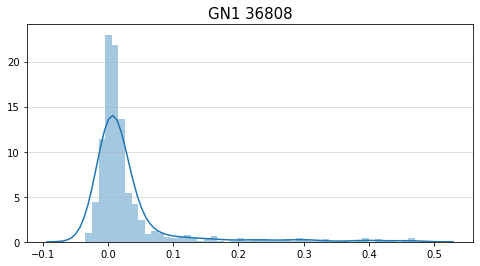

The Standard Deviation for GN1 36808 is: 0.27508585699229554
----------------------------------------------------------------


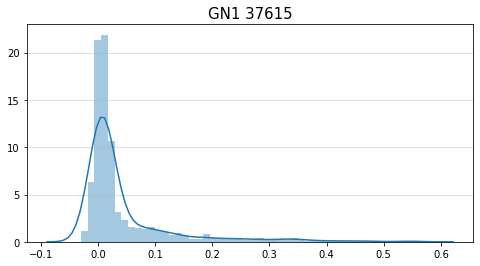

The Standard Deviation for GN1 37615 is: 0.3430554748120011
----------------------------------------------------------------


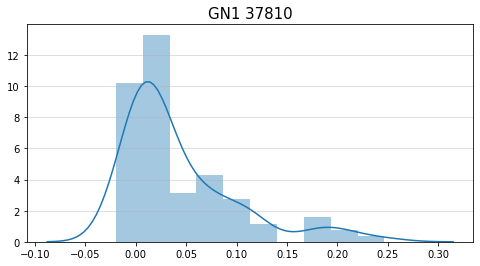

The Standard Deviation for GN1 37810 is: 0.3817392125376811
----------------------------------------------------------------


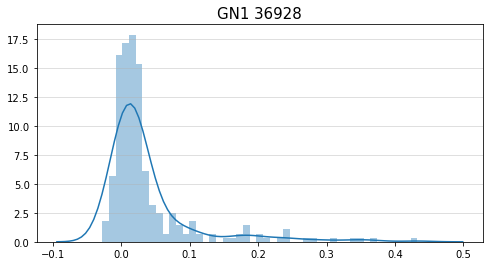

The Standard Deviation for GN1 36928 is: 0.3064182139889041
----------------------------------------------------------------


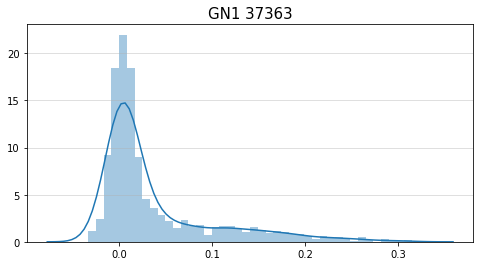

The Standard Deviation for GN1 37363 is: 0.36330737604810937
----------------------------------------------------------------


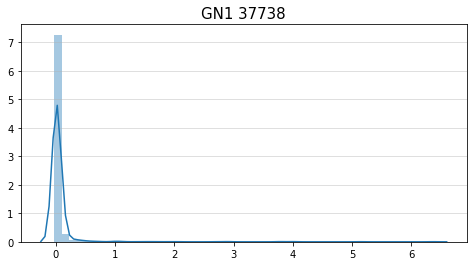

The Standard Deviation for GN1 37738 is: 0.25882235854057645
----------------------------------------------------------------


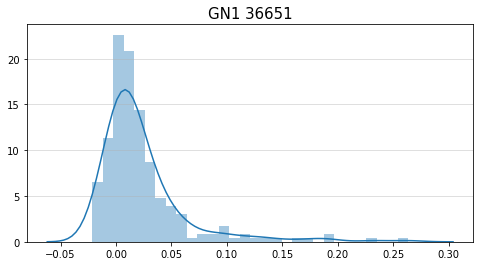

The Standard Deviation for GN1 36651 is: 0.217089678290309
----------------------------------------------------------------


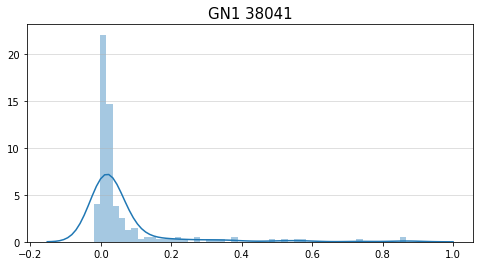

The Standard Deviation for GN1 38041 is: 0.31611866773914865
----------------------------------------------------------------


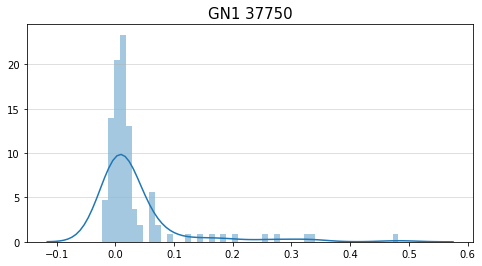

The Standard Deviation for GN1 37750 is: 0.29230062990244654
----------------------------------------------------------------


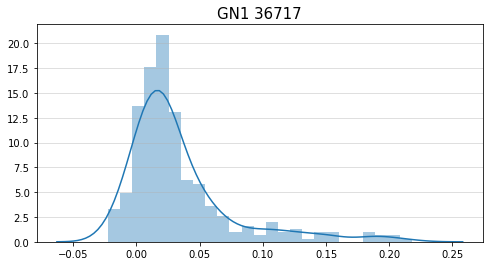

The Standard Deviation for GN1 36717 is: 0.28296637232342964
----------------------------------------------------------------


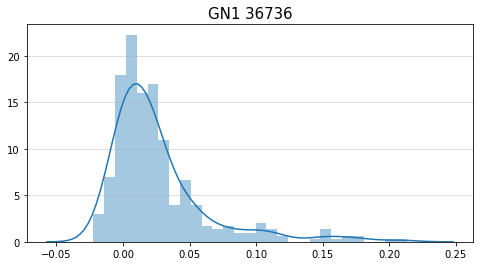

The Standard Deviation for GN1 36736 is: 0.24114576006841015
----------------------------------------------------------------


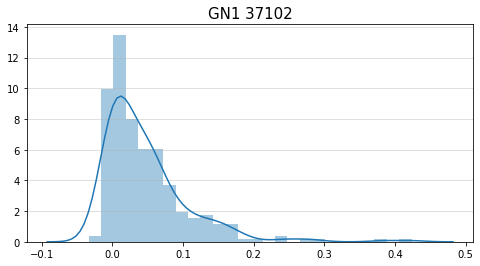

The Standard Deviation for GN1 37102 is: 0.3514239288465838
----------------------------------------------------------------


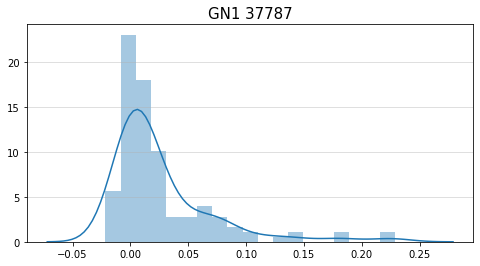

The Standard Deviation for GN1 37787 is: 0.24944382578492943
----------------------------------------------------------------


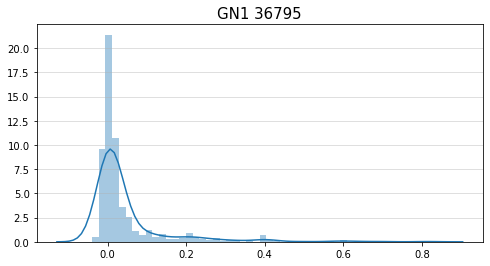

The Standard Deviation for GN1 36795 is: 0.34415459395979336
----------------------------------------------------------------


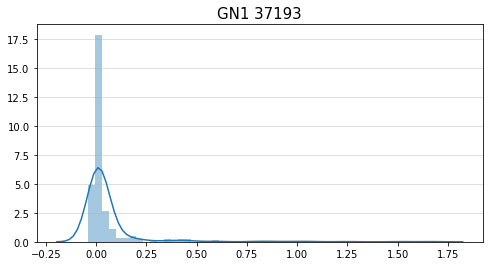

The Standard Deviation for GN1 37193 is: 0.29694553859683087
----------------------------------------------------------------


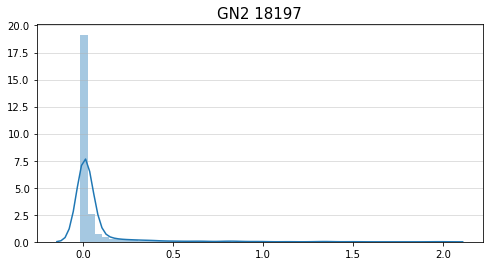

The Standard Deviation for GN2 18197 is: 0.31011604362466033
----------------------------------------------------------------


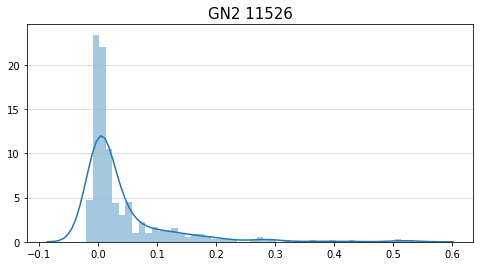

The Standard Deviation for GN2 11526 is: 0.33926134742544833
----------------------------------------------------------------


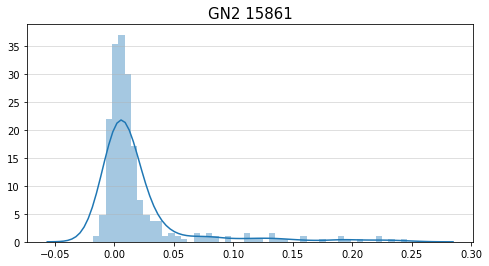

The Standard Deviation for GN2 15861 is: 0.23653966850026178
----------------------------------------------------------------


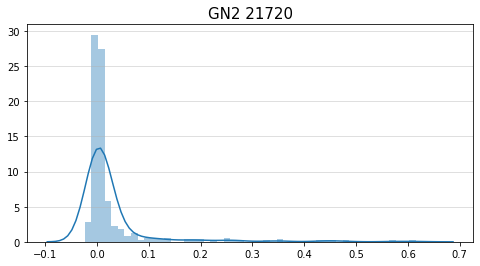

The Standard Deviation for GN2 21720 is: 0.2629750205043988
----------------------------------------------------------------


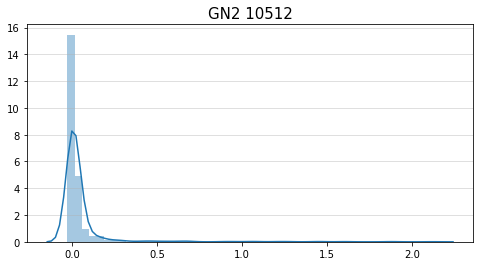

The Standard Deviation for GN2 10512 is: 0.27525608008494573
----------------------------------------------------------------


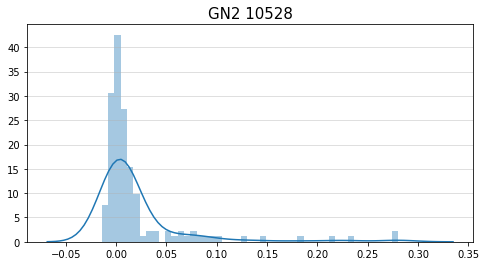

The Standard Deviation for GN2 10528 is: 0.22757873597035824
----------------------------------------------------------------


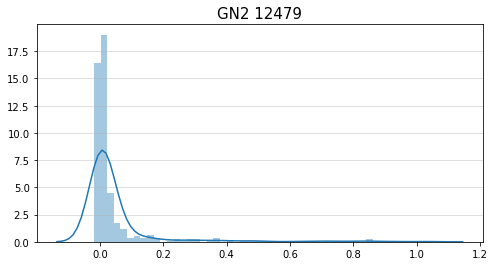

The Standard Deviation for GN2 12479 is: 0.2948610360732959
----------------------------------------------------------------


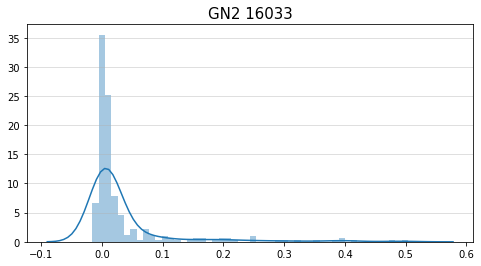

The Standard Deviation for GN2 16033 is: 0.2927132040293261
----------------------------------------------------------------


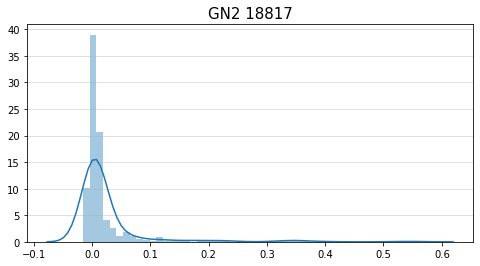

The Standard Deviation for GN2 18817 is: 0.24753555525477863
----------------------------------------------------------------


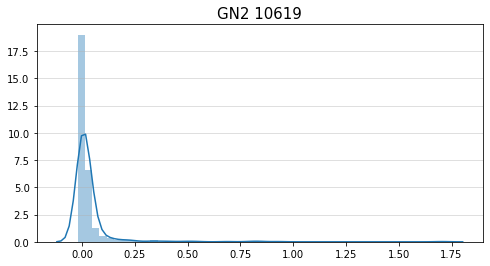

The Standard Deviation for GN2 10619 is: 0.2430211689554873
----------------------------------------------------------------


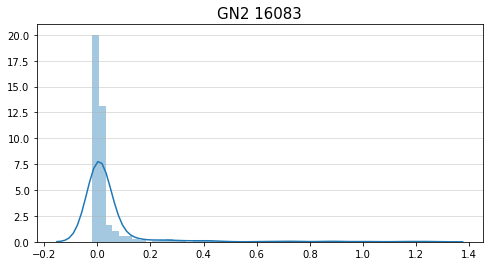

The Standard Deviation for GN2 16083 is: 0.27704202210100426
----------------------------------------------------------------


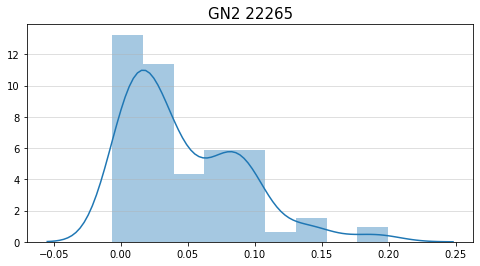

The Standard Deviation for GN2 22265 is: 0.2981128237819257
----------------------------------------------------------------


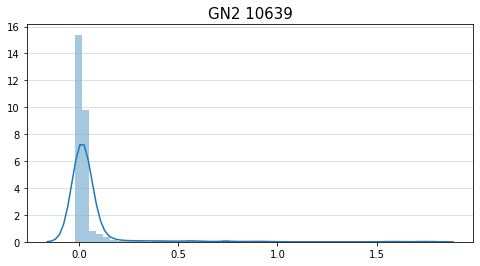

The Standard Deviation for GN2 10639 is: 0.24454272795614224
----------------------------------------------------------------


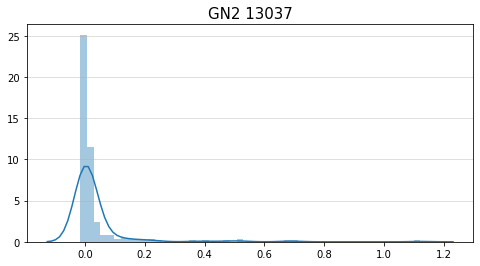

The Standard Deviation for GN2 13037 is: 0.26513719386196666
----------------------------------------------------------------


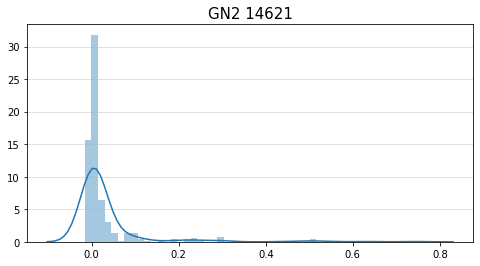

The Standard Deviation for GN2 14621 is: 0.25648454418034405
----------------------------------------------------------------


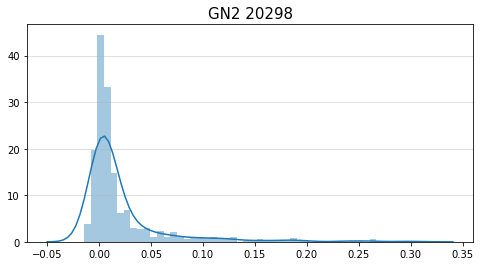

The Standard Deviation for GN2 20298 is: 0.23281069268034096
----------------------------------------------------------------


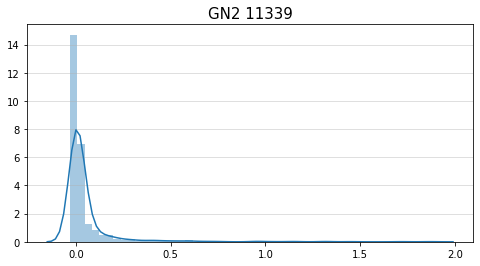

The Standard Deviation for GN2 11339 is: 0.31587569517986236
----------------------------------------------------------------


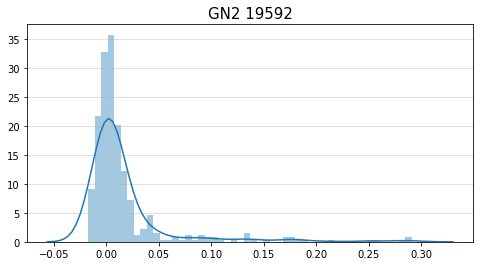

The Standard Deviation for GN2 19592 is: 0.22599916885904603
----------------------------------------------------------------


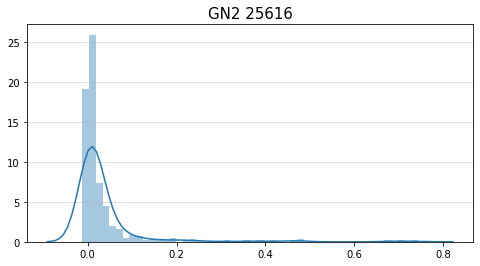

The Standard Deviation for GN2 25616 is: 0.2639985032475115
----------------------------------------------------------------


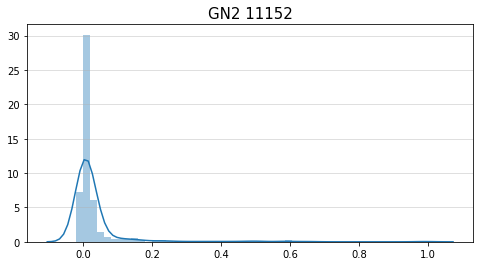

The Standard Deviation for GN2 11152 is: 0.25187476206605397
----------------------------------------------------------------


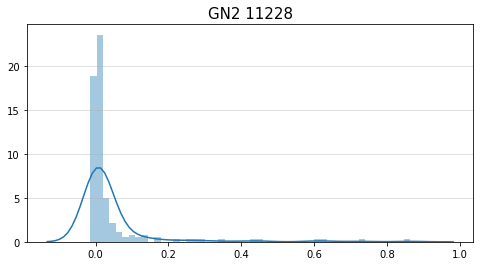

The Standard Deviation for GN2 11228 is: 0.3012777891133327
----------------------------------------------------------------


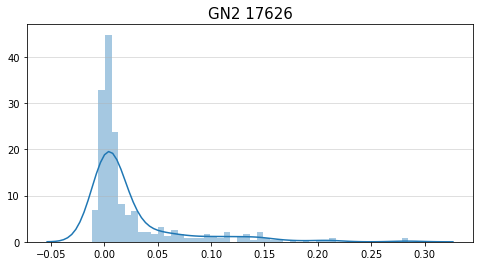

The Standard Deviation for GN2 17626 is: 0.28450180405056574
----------------------------------------------------------------


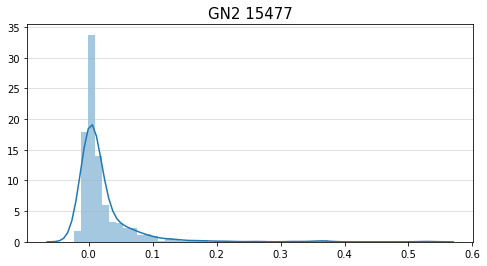

The Standard Deviation for GN2 15477 is: 0.21207237712401117
----------------------------------------------------------------


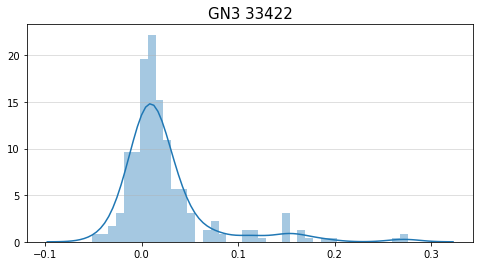

The Standard Deviation for GN3 33422 is: 0.27413687078392535
----------------------------------------------------------------


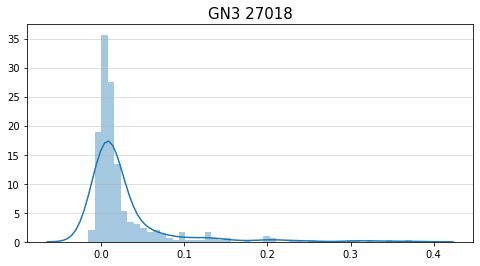

The Standard Deviation for GN3 27018 is: 0.2606257270084532
----------------------------------------------------------------


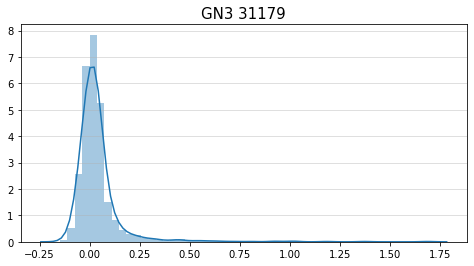

The Standard Deviation for GN3 31179 is: 0.3225036444446016
----------------------------------------------------------------


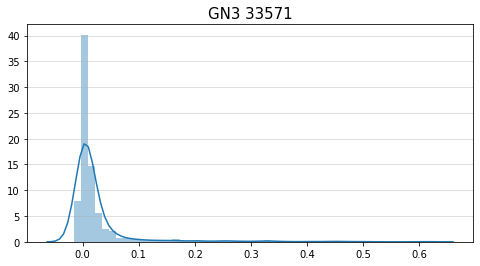

The Standard Deviation for GN3 33571 is: 0.22555028992906484
----------------------------------------------------------------


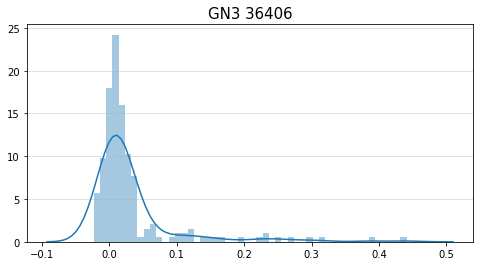

The Standard Deviation for GN3 36406 is: 0.29417083538639993
----------------------------------------------------------------


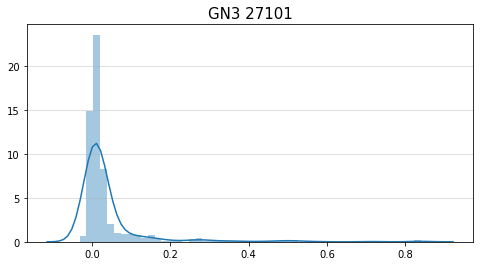

The Standard Deviation for GN3 27101 is: 0.2907626376902529
----------------------------------------------------------------


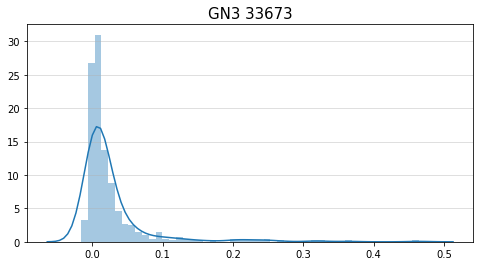

The Standard Deviation for GN3 33673 is: 0.2358148622134752
----------------------------------------------------------------


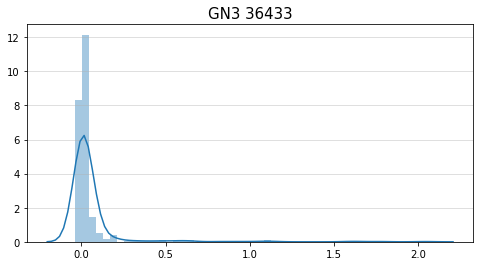

The Standard Deviation for GN3 36433 is: 0.27334256629373294
----------------------------------------------------------------


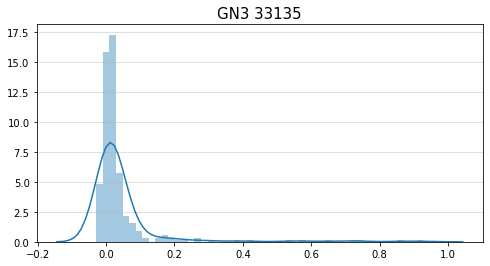

The Standard Deviation for GN3 33135 is: 0.2738042421428314
----------------------------------------------------------------


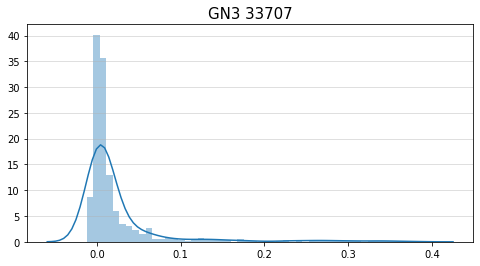

The Standard Deviation for GN3 33707 is: 0.24855082939491352
----------------------------------------------------------------


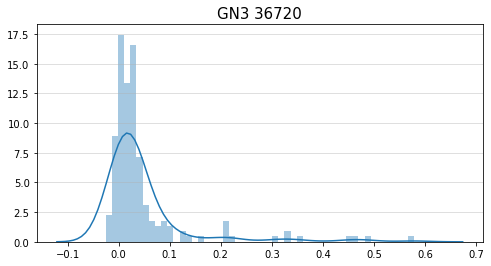

The Standard Deviation for GN3 36720 is: 0.30357018555889664
----------------------------------------------------------------


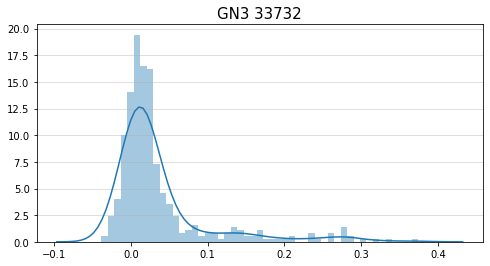

The Standard Deviation for GN3 33732 is: 0.3173690919038396
----------------------------------------------------------------


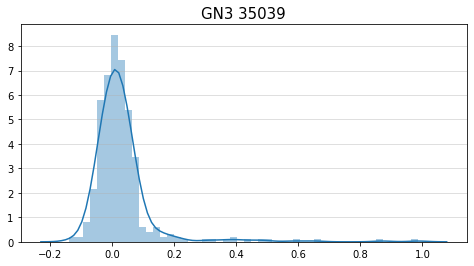

The Standard Deviation for GN3 35039 is: 0.26078294318443845
----------------------------------------------------------------


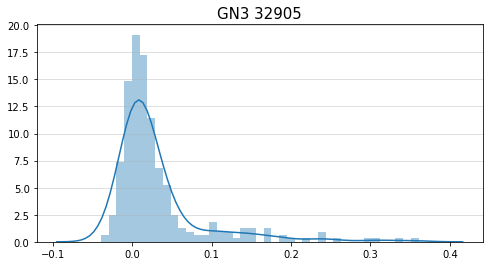

The Standard Deviation for GN3 32905 is: 0.3070960024331282
----------------------------------------------------------------


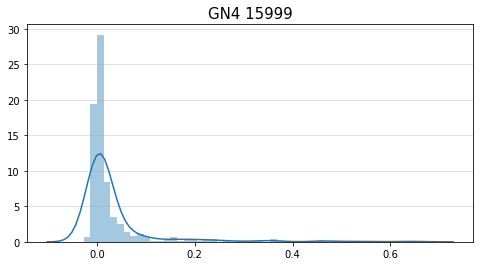

The Standard Deviation for GN4 15999 is: 0.27835369579288854
----------------------------------------------------------------


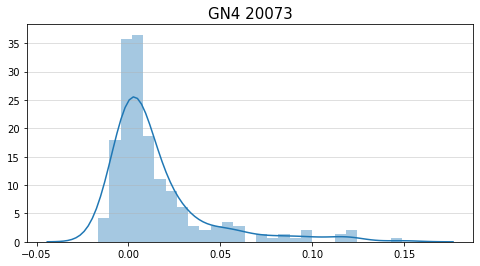

The Standard Deviation for GN4 20073 is: 0.15708447653152982
----------------------------------------------------------------


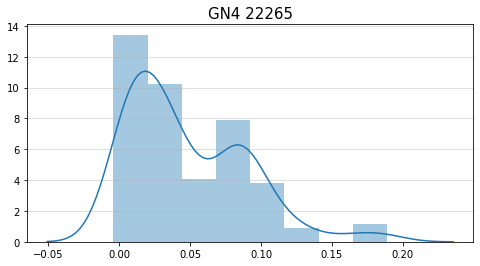

The Standard Deviation for GN4 22265 is: 0.3073683498985239
----------------------------------------------------------------


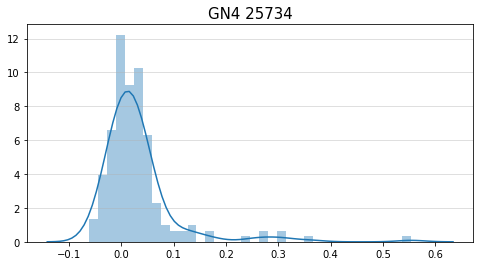

The Standard Deviation for GN4 25734 is: 0.2867475150384073
----------------------------------------------------------------


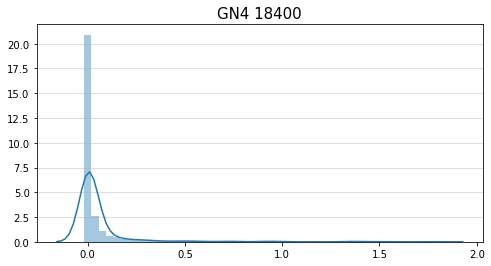

The Standard Deviation for GN4 18400 is: 0.3142696805273545
----------------------------------------------------------------


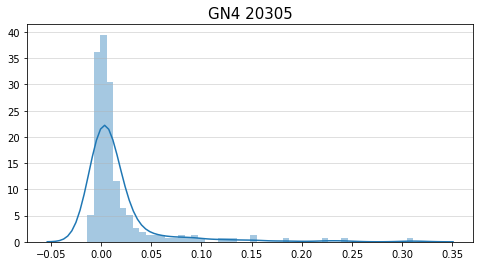

The Standard Deviation for GN4 20305 is: 0.19074889853472546
----------------------------------------------------------------


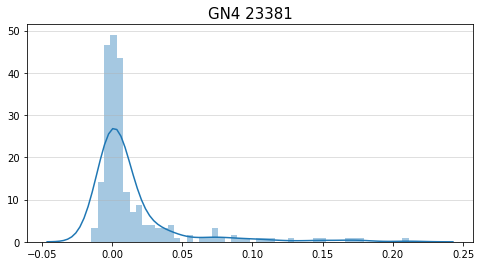

The Standard Deviation for GN4 23381 is: 0.1855768722395226
----------------------------------------------------------------


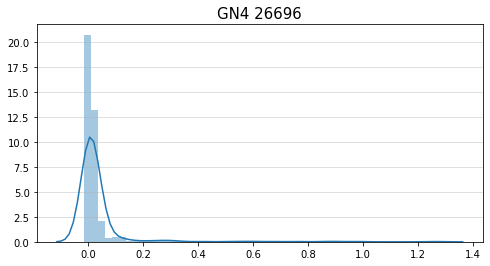

The Standard Deviation for GN4 26696 is: 0.23190799516314684
----------------------------------------------------------------


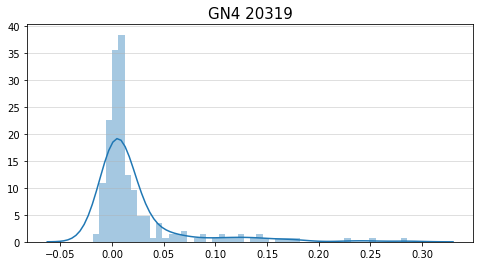

The Standard Deviation for GN4 20319 is: 0.25654623798103576
----------------------------------------------------------------


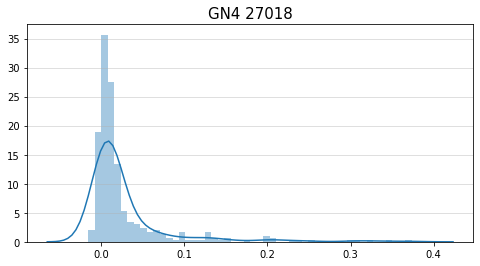

The Standard Deviation for GN4 27018 is: 0.2606257270084532
----------------------------------------------------------------


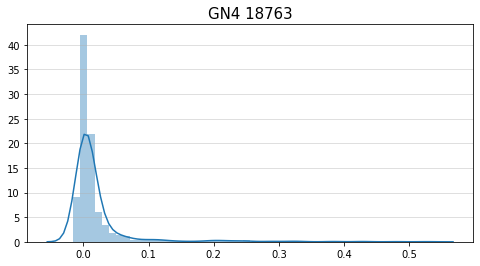

The Standard Deviation for GN4 18763 is: 0.21429354587930524
----------------------------------------------------------------


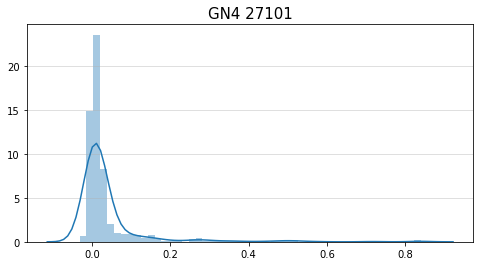

The Standard Deviation for GN4 27101 is: 0.2907626376902529
----------------------------------------------------------------


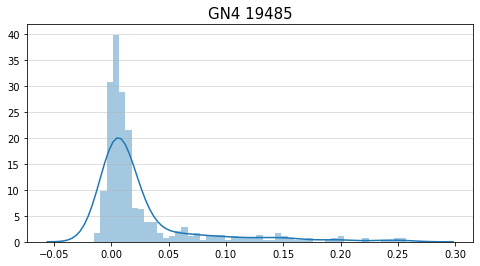

The Standard Deviation for GN4 19485 is: 0.27591073827065526
----------------------------------------------------------------


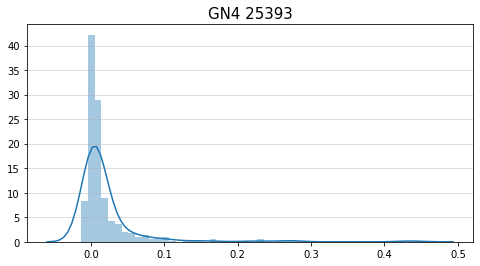

The Standard Deviation for GN4 25393 is: 0.20829889522526548
----------------------------------------------------------------


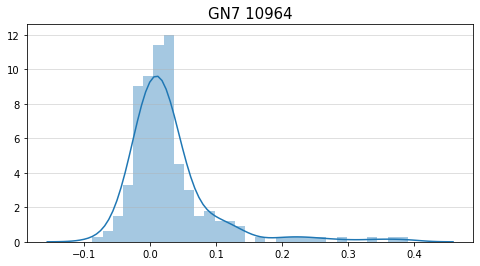

The Standard Deviation for GN7 10964 is: 0.29626012510696587
----------------------------------------------------------------


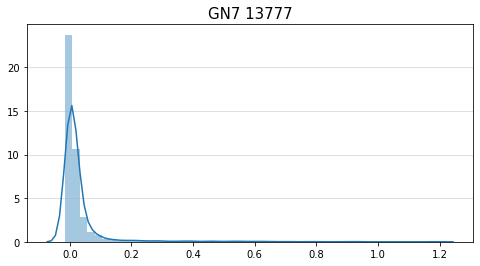

The Standard Deviation for GN7 13777 is: 0.23717519388364244
----------------------------------------------------------------


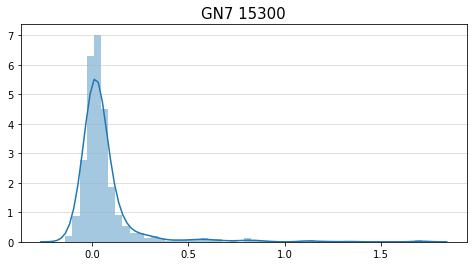

The Standard Deviation for GN7 15300 is: 0.3726779962499649
----------------------------------------------------------------


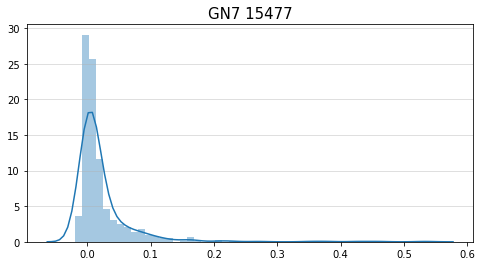

The Standard Deviation for GN7 15477 is: 0.21207237712401117
----------------------------------------------------------------


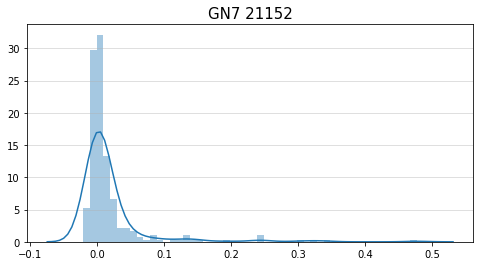

The Standard Deviation for GN7 21152 is: 0.22219509383022443
----------------------------------------------------------------


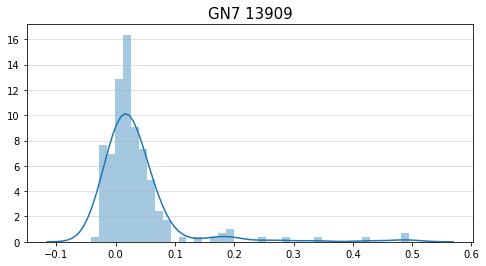

The Standard Deviation for GN7 13909 is: 0.2472664776695879
----------------------------------------------------------------


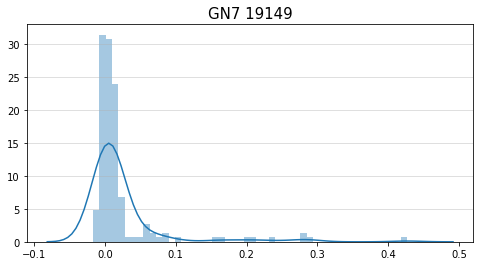

The Standard Deviation for GN7 19149 is: 0.23860629921247906
----------------------------------------------------------------


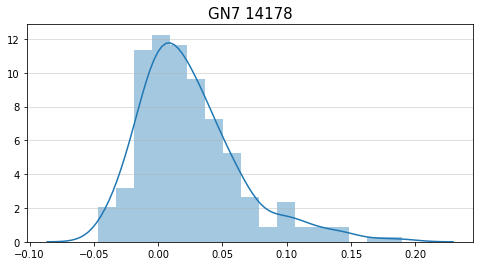

The Standard Deviation for GN7 14178 is: 0.23928557158961683
----------------------------------------------------------------


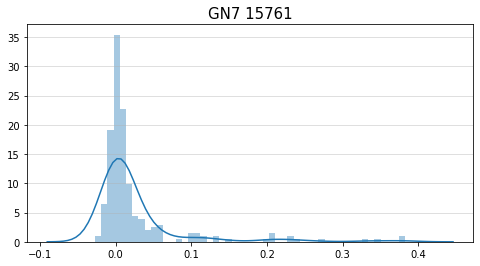

The Standard Deviation for GN7 15761 is: 0.2722894034860344
----------------------------------------------------------------


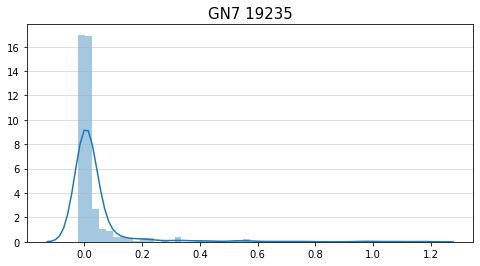

The Standard Deviation for GN7 19235 is: 0.27431476279805755
----------------------------------------------------------------


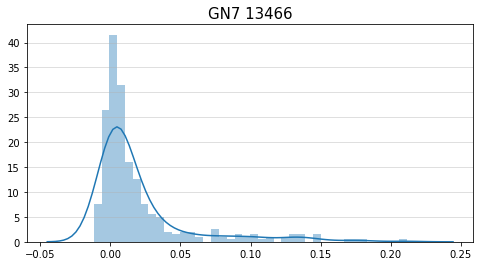

The Standard Deviation for GN7 13466 is: 0.23498577411226934
----------------------------------------------------------------


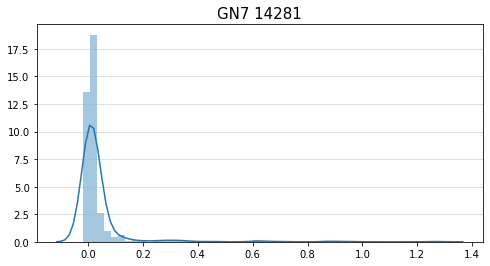

The Standard Deviation for GN7 14281 is: 0.2475355552547787
----------------------------------------------------------------


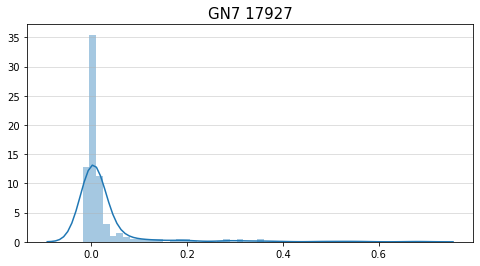

The Standard Deviation for GN7 17927 is: 0.2538823099698526
----------------------------------------------------------------


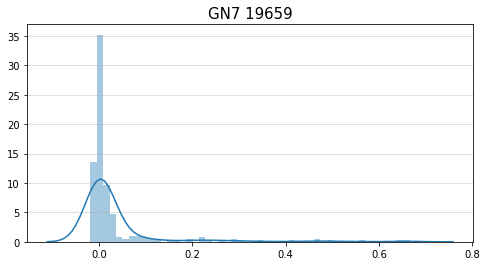

The Standard Deviation for GN7 19659 is: 0.26937494979425247
----------------------------------------------------------------


In [14]:
#Finding the Standard Deviation of each galaxies Original images (The Noise Level)
orig_std = []
gal_avg = []
gal_data = []

for i in range(len(Gal_Orig)):
    pos_val = []
    for j in range(len(Gal_Orig[i])):
        for k in range(len(Gal_Orig[i][j])):
            if Gal_Orig[i][j][k] > -99:
                pos_val.append(Gal_Orig[i][j][k])
                
                #print(Gal_idx[n][i][j][k])
                
    plt.figure(figsize = [8,4])
    plt.title(Std_Title[i],fontsize = 15)
    sea.distplot(np.ravel(pos_val))
    plt.grid(axis = 'y', alpha = .5)
    plt.show()
    RIMG = np.ravel(pos_val)
    std = np.std(RIMG < .1)
    orig_std.append(std)
    gal_avg.append(np.sum(pos_val)/len(pos_val))
    gal_data.append(pos_val)
    
    print("The Standard Deviation for "+str(Std_Title[i])+" is: "+str(std))
    print("----------------------------------------------------------------")

Finding the Signal to Noise fraction using this Equation:

$$ SN = \frac{\mu}{\sigma} $$

Where $\sigma$ is our standard deviation for each galaxy (our noise level), and our $\mu$ is the average value in said galaxy (our signal).

In [15]:
#Finding the Signal to Noise
GN1_SN = []
GN2_SN = []
GN3_SN = []
GN4_SN = []
GN7_SN = []
Gal_SN = []

for i in range(len(Std_Title)):
    if i < 15:                              #GN1
        GN1_SN.append(gal_avg[i]/orig_std[i])
        Gal_SN.append(gal_avg[i]/orig_std[i])
        
    if i < 38 and i > 14:                   #GN2
        GN2_SN.append(gal_avg[i]/orig_std[i])
        Gal_SN.append(gal_avg[i]/orig_std[i])
        
    if i < 52 and i > 37:                   #GN3
        GN3_SN.append(gal_avg[i]/orig_std[i])
        Gal_SN.append(gal_avg[i]/orig_std[i])
        
    if i < 66 and i > 51:                   #GN4
        GN4_SN.append(gal_avg[i]/orig_std[i])
        Gal_SN.append(gal_avg[i]/orig_std[i])
        
    if i < 80 and i > 65:                   #GN7
        GN7_SN.append(gal_avg[i]/orig_std[i])
        Gal_SN.append(gal_avg[i]/orig_std[i])

#Finding the average Signal to noise in each field
GN1_avg = np.sum(GN1_SN)/len(GN1_SN)
GN2_avg = np.sum(GN2_SN)/len(GN2_SN)
GN3_avg = np.sum(GN3_SN)/len(GN3_SN)
GN4_avg = np.sum(GN4_SN)/len(GN2_SN) 
GN7_avg = np.sum(GN7_SN)/len(GN2_SN)
        
print("The average Signal to noise fraction for GN1 is: " + str(GN1_avg))
print("The average Signal to noise fraction for GN2 is: " + str(GN2_avg))
print("The average Signal to noise fraction for GN3 is: " + str(GN3_avg))
print("The average Signal to noise fraction for GN4 is: " + str(GN4_avg))
print("The average Signal to noise fraction for GN7 is: " + str(GN7_avg))

The average Signal to noise fraction for GN1 is: 0.13400143607223067
The average Signal to noise fraction for GN2 is: 0.12416240629553447
The average Signal to noise fraction for GN3 is: 0.12143890393881988
The average Signal to noise fraction for GN4 is: 0.06756124814588196
The average Signal to noise fraction for GN7 is: 0.06988950831102615


In [16]:
#Combining all the new data in a dataframe for ease of convienience
data = {'Field':Field,'Galaxy ID':ID,'Standard Deviation':orig_std,'Signal to Noise':Gal_SN,'Galaxy Data':gal_data}
Gal_3sigma = pd.DataFrame(data)

#Gal_3sigma.to_csv(r'/Users/felixmartinez/Research/Merging_Tables/Gal_3sigma_SN.csv')
Gal_3sigma

Field  Galaxy ID  Standard Deviation  Signal to Noise  \
0    GN1      36808            0.275086         0.111064   
1    GN1      37615            0.343055         0.126241   
2    GN1      37810            0.381739         0.112332   
3    GN1      36928            0.306418         0.122503   
4    GN1      37363            0.363307         0.101486   
5    GN1      37738            0.258822         0.237056   
6    GN1      36651            0.217090         0.107451   
7    GN1      38041            0.316119         0.184281   
8    GN1      37750            0.292301         0.122418   
9    GN1      36717            0.282966         0.118631   
10   GN1      36736            0.241146         0.108621   
11   GN1      37102            0.351424         0.133491   
12   GN1      37787            0.249444         0.106179   
13   GN1      36795            0.344155         0.132854   
14   GN1      37193            0.296946         0.185414   
15   GN2      18197            0.310116         0.176361   
16   GN2      11526            0.339261         0.116093   
17   GN2      15861            0.236540         0.085775   
18   GN2      21720            0.262975         0.103043   
19   GN2      10512            0.275256         0.167533   
20   GN2      10528            0.227579         0.088624   
21   GN2      12479            0.294861         0.153776   
22   GN2      16033            0.292713         0.111486   
23   GN2      18817            0.247536         0.099980   
24   GN2      10619            0.243021         0.131631   
25   GN2      16083            0.277042         0.151999   
26   GN2      22265            0.298113         0.158393   
27   GN2      10639            0.244543         0.187540   
28   GN2      13037            0.265137         0.119678   
29   GN2      14621            0.256485         0.122721   
..   ...        ...                 ...              ...   
50   GN3      35039            0.260783         0.114565   
51   GN3      32905            0.307096         0.099799   
52   GN4      15999            0.278354         0.116166   
53   GN4      20073            0.157084         0.096436   
54   GN4      22265            0.307368         0.156914   
55   GN4      25734            0.286748         0.111037   
56   GN4      18400            0.314270         0.169651   
57   GN4      20305            0.190749         0.085036   
58   GN4      23381            0.185577         0.071837   
59   GN4      26696            0.231908         0.147191   
60   GN4      20319            0.256546         0.083888   
61   GN4      27018            0.260626         0.105356   
62   GN4      18763            0.214294         0.089725   
63   GN4      27101            0.290763         0.129111   
64   GN4      19485            0.275911         0.093812   
65   GN4      25393            0.208299         0.097750   
66   GN7      10964            0.296260         0.100664   
67   GN7      13777            0.237175         0.128876   
68   GN7      15300            0.372678         0.168189   
69   GN7      15477            0.212072         0.104370   
70   GN7      21152            0.222195         0.084075   
71   GN7      13909            0.247266         0.143170   
72   GN7      19149            0.238606         0.098090   
73   GN7      14178            0.239286         0.103260   
74   GN7      15761            0.272289         0.093214   
75   GN7      19235            0.274315         0.137026   
76   GN7      13466            0.234986         0.084936   
77   GN7      14281            0.247536         0.145069   
78   GN7      17927            0.253882         0.101573   
79   GN7      19659            0.269375         0.114945   

                                          Galaxy Data  
0   [0.018676903, -0.004062644, -0.0052428865, 0.0...  
1   [-0.010747199, -0.005684848, 0.018701104, 0.00...  
2   [-0.002236538, -0.013589742, -0.009006394, 0.0...  
3   [-0.0076499125, -0.01359708, -0.022275366, -0....  
4 

# Filter Testing

We will be applying the Average SN values to the simulated Galaxies covered previously. The worst SN is GN1 with a $\sigma = 0.134$, we wil use this for our worst case scenario. We will also be testing a gaussian filter along with no filter to see which filter would be the most optomized for our data. (We want our data to peak at zero)

In [22]:
#Making a loop to test the median filter with the measured background noise

#First a perfect, spherical simulated galaxy:
RANGE = np.arange(0,40)
dist = func.gauss_dist(RANGE, 20,2)

IMG = np.zeros([len(RANGE), len(RANGE)])

for i in range(len(RANGE)):
    for ii in range(len(RANGE)):
        IMG[i][ii] = dist[i]*dist[ii]
IMG /= np.max(IMG)                      #This is the perfect galaxy

#The perfect galaxy is held outside the loop as it is unchanging throughout each itteration
n = 0
Standard_x = []
Standard_y = []
Median_x = []
Median_y = []

#Finally we must select our noise level: 
#(We choose the worst average noise level found in GN1)
Noise_lvl = 0.134

while n < 1000:
    #Now adding the noise factor:
    #(We add this in the loop as we want it to be different in every itteration)
    NOISE = np.random.normal(0,Noise_lvl,size = IMG.shape)
    
    NIMG = IMG + NOISE                                 #This is the galaxy with added noise
    
    Perfect_max = np.where(IMG == np.max(IMG))
    Noise_max = np.where(NIMG == np.max(NIMG))

    #Appending the offset for the noise:
    Standard_x.append(Noise_max[0][0] - Perfect_max[0][0])  #x offset
    Standard_y.append(Noise_max[1][0] - Perfect_max[1][0])  #y offset

    #Now applying the Median Filter: (using a 3x3 approximation)
    MEDIMG = ndimage.median_filter(NIMG, size = (3,3))          #This is the galaxy with the Median Filter
   
    Median_max = np.where(MEDIMG == np.max(MEDIMG))
    
    #Appending the offset for the Median Filter noise:
    Median_x.append(Median_max[0][0] - Perfect_max[0][0])  #x offset
    Median_y.append(Median_max[1][0] - Perfect_max[1][0])  #y offset
    
    n = n + 1

#Calculating the Standard Deviation for each of our Measurments:
Medx_std , Medy_std = np.std(Median_x) , np.std(Median_y)
Standx_std , Standy_std = np.std(Standard_x) , np.std(Standard_y)

The Standard Deviation for Median Filter X is: 0.36
The Standard Deviation for Random Noise X is: 0.6107

The Standard Deviation for Median Filter Y is: 0.3653
The Standard Deviation for Random Noise Y is: 0.6006


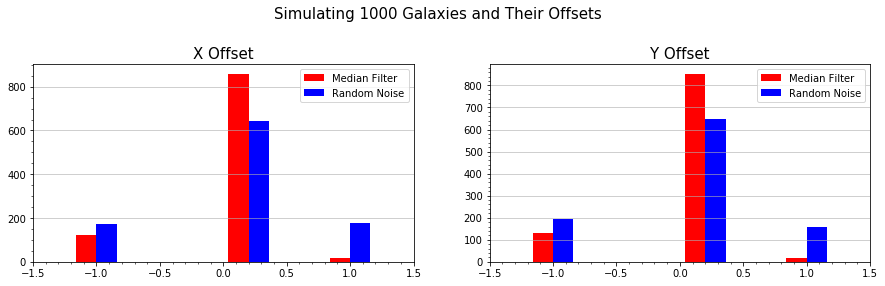

In [23]:
print("The Standard Deviation for Median Filter X is: " + str(round(Medx_std,4)))
print("The Standard Deviation for Random Noise X is: " + str(round(Standx_std,4)))
print("")
print("The Standard Deviation for Median Filter Y is: " + str(round(Medy_std,4)))
print("The Standard Deviation for Random Noise Y is: " + str(round(Standy_std,4)))


#Making the Histogram of our Data
plt.figure(figsize=[15,8])

#X offset plot
plt.subplot(221)
plt.hist((Median_x,Standard_x),color = ('red','blue'), label = ('Median Filter','Random Noise'))
plt.grid(axis = 'y',alpha = .75)
plt.minorticks_on()
plt.title("X Offset",fontsize = 15)
plt.legend()
plt.xlim(-1.5,1.5)

#Y offset plot
plt.subplot(222)
plt.hist((Median_y,Standard_y),color = ('red','blue'), label = ('Median Filter','Random Noise'))
plt.grid(axis = 'y',alpha = .75)
plt.minorticks_on()
plt.title("Y Offset",fontsize = 15)
plt.legend()
plt.xlim(-1.5,1.5)

plt.suptitle('Simulating 1000 Galaxies and Their Offsets',fontsize=15)

plt.show()

In [24]:
#Making a loop to test the median filter with the measured background noise
#First a perfect, spherical simulated galaxy:
RANGE = np.arange(0,40)
dist = func.gauss_dist(RANGE, 20,2)

IMG = np.zeros([len(RANGE), len(RANGE)])

for i in range(len(RANGE)):
    for ii in range(len(RANGE)):
        IMG[i][ii] = dist[i]*dist[ii]
IMG /= np.max(IMG)                      #This is the perfect galaxy

#The perfect galaxy is held outside the loop as it is unchanging throughout each itteration
n = 0
Standard_x = []
Standard_y = []
Median_x = []
Median_y = []
Gauss_x = []
Gauss_y = []

#Finally we must select our noise level: 
#(We choose the worst average noise level found in GN1)
Noise_lvl = 0.134

while n < 1000:
    
    #Adding a random Bright Pixel within the galaxy
    max_index = np.random.choice([18,19,20,21,22], 2)  #seclecting the location
    max_val = 1.1 * np.max(IMG)                        #setting the bright pxl to be 1.1 X our previous bright pxl
    IMG[max_index[0], max_index[1]]=max_val
    
    #Now adding the noise factor:
    #(We add this in the loop as we want it to be different in every itteration)
    NOISE = np.random.normal(0,Noise_lvl,size = IMG.shape)
    
    NIMG = IMG + NOISE                                 #This is the galaxy with added noise
    
    Perfect_max = np.where(IMG == np.max(IMG))
    Noise_max = np.where(NIMG == np.max(NIMG))

    #Appending the offset for the noise:
    Standard_x.append(Perfect_max[0][0] - Noise_max[0][0])  #x offset
    Standard_y.append(Perfect_max[1][0] - Noise_max[1][0])  #y offset

    #Now applying the Median Filter: (using a 3x3 approximation)
    MEDIMG = ndimage.median_filter(NIMG, size = (3,3))          #This is the galaxy with the Median Filter
   
    Median_max = np.where(MEDIMG == np.max(MEDIMG))
    
    #Appending the offset for the Median Filter noise:
    Median_x.append(Perfect_max[0][0] - Median_max[0][0])  #x offset
    Median_y.append(Perfect_max[1][0] - Median_max[1][0])  #y offset
    
    #Trying a Gaussian filter
    GAUSSIMG = ndimage.gaussian_filter(NIMG,1)
    
    Gauss_max = np.where(GAUSSIMG == np.max(GAUSSIMG))
    
    #Appending the offset for the Median Filter noise:
    Gauss_x.append(Perfect_max[0][0] - Gauss_max[0][0])  #x offset
    Gauss_y.append(Perfect_max[1][0] - Gauss_max[1][0])  #y offset
    
    n = n + 1

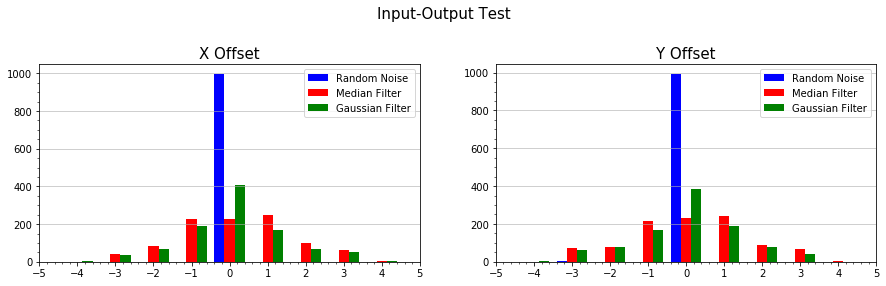

In [25]:
#Making the Histogram of our Data
plt.figure(figsize=[15,8])
ticks=[x for x in range(-5,6)]

#X offset plot
plt.subplot(221)
plt.hist((Standard_x,Median_x,Gauss_x),color = ('blue','red','green'), 
         label = ('Random Noise','Median Filter','Gaussian Filter'), bins=np.arange(-3,7) - 1.5)
plt.grid(axis = 'y',alpha = .75)
plt.minorticks_on()
plt.title("X Offset",fontsize = 15)
plt.xticks(ticks)
plt.legend()

#Y offset plot
plt.subplot(222)
plt.hist((Standard_y,Median_y,Gauss_y),color = ('blue','red','green'), 
         label = ('Random Noise','Median Filter','Gaussian Filter'), bins=np.arange(-3,7) - 1.5)
plt.grid(axis = 'y',alpha = .75)
plt.minorticks_on()
plt.title("Y Offset",fontsize = 15)
plt.xticks(ticks)
plt.legend()

plt.suptitle('Input-Output Test',fontsize=15)

plt.show()

With this unnexpected result, we will attempt to find the merger offset without filtering our data, instead only using random noise. We may alos try the Gaussian filter instead, as this filter tested better than the Median Filter